In [ ]:
!pip install catboost
!pip install optuna
!pip install dalex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.1-py3-none-any.whl size=1042797 sha256=dce72260f324e436df716045d2285946913effae63a01cbf124515230755b5da
  Stored in directory: /root/.cache/pip/wheels/50/24/3e/5a88876cfa3bd019ba82ec57c228eae1a37f479c0f8353e5cb
Successfully built dalex


# Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from geopy.distance import geodesic
from scipy.stats import pointbiserialr
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import optuna

import dalex as dx

# setting yang diperlukan
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None) # setting pandas agar menampilkan semua kolom jika kolom terlalu banyak
plt.style.use('dark_background') # dark mode for visualization
sns.set_palette('bright') # global color palette

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FinproDS28 - Muhammad Reza Adi Kusuma/Airbnb pricing.csv')
df.head(10)

id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
3  13418779   6.620073         House  Entire home/apt   
4   3808709   4.744932     Apartment  Entire home/apt   
5  12422935   4.442651     Apartment     Private room   
6  11825529   4.418841     Apartment  Entire home/apt   
7  13971273   4.787492   Condominium  Entire home/apt   
8    180792   4.787492         House     Private room   
9   5385260   3.583519         House     Private room   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   
5  {TV,"Wireless Internet",Heating,"Smoke detecto...             2        1.0   
6  {TV,Internet,"Wireless Internet","Air conditio...             3        1.0   
7  {TV,"Cable TV","Wireless Internet","Wheelchair...             2        1.0   
8  {TV,"Cable TV","Wireless Internet","Pets live ...             2        1.0   
9  {"Wireless Internet","Air conditioning",Kitche...             2        1.0   

   bed_type cancellation_policy  cleaning_fee city  \
0  Real Bed              strict          True  NYC   
1  Real Bed              strict          True  NYC   
2  Real Bed            moderate          True  NYC   
3  Real Bed            flexible          True   SF   
4  Real Bed            moderate          True   DC   
5  Real Bed              strict          True   SF   
6  Real Bed            moderate          True   LA   
7  Real Bed            moderate          True   LA   
8  Real Bed            moderate          True   SF   
9  Real Bed            moderate          True   LA   

                                         description first_review  \
0  Beautiful, sunlit brownstone 1-bedroom in the ...   2016-06-18   
1  Enjoy travelling during your stay in Manhattan...   2017-08-05   
2  The Oasis comes complete with a full backyard ...   2017-04-30   
3  This light-filled home-away-from-home is super...          NaN   
4  Cool, cozy, and comfortable studio located in ...   2015-05-12   
5  Beautiful private room overlooking scenic view...   2017-08-27   
6  Warm and cozy studio with full kitchen and bat...   2017-03-10   
7  Arguably the best location (and safest) in dow...   2016-12-16   
8  Garden Studio with private entrance from the s...   2016-02-13   
9  Quiet community. Close to supermarkets,restaur...   2017-04-03   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      t                NaN  2012-03-26   
1                    t                      f               100%  2017-06-19   
2                    t                      t               100%  2016-10-25   
3                    t                      t                NaN  2015-04-19   
4                    t                      t               100%  2015-03-01   
5                    t                      t               100%  2017-06-07   
6                    t                      f               100%  2017-03-03   
7                    t                      t               100%  2013-05-18   
8                    t                      f               100%  2015-06-04   
9                    t                      f               100%  2017-03-12   

  instant_bookable last_review   latitude   longitude  \
0                f  2016-07-18  40.696524  -73.991617   
1                t  2017-09-23  40.766115  -73.989040   
2                t  2017-09-14  40.808110  -73.943756   
3                f       

In [ ]:
# melihat sekilas keseluruhan meta data, jumlah baris, dan jumlah missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

id: ID unik untuk setiap listing.  
log_price: Logaritma natural dari harga listing.  
property_type: Jenis properti.  
room_type: Jenis ruang yang disewakan  
amenities: Fasilitas yang tersedia dalam listing.  
accommodates: Jumlah tamu yang dapat ditampung.  
bathrooms: Jumlah kamar mandi.  
bed_type: Jenis tempat tidur yang disediakan  
cancellation_policy: Kebijakan pembatalan untuk listing.  
cleaning_fee: Apakah ada biaya kebersihan.  
city: Kota tempat properti berada.  
description: Deskripsi properti oleh pemilik.  
first_review: Tanggal ulasan pertama pada listing.  
host_has_profile_pic: Apakah pemilik memiliki foto profil.  
host_identity_verified: Apakah identitas pemilik diverifikasi.  
host_response_rate: Persentase tingkat respons pemilik.  
host_since: Tanggal sejak pemilik aktif di platform.  
instant_bookable: Apakah listing dapat dipesan secara instan.  
last_review: Tanggal ulasan terakhir pada listing.  
latitude: Garis lintang properti.  
longitude: Garis bujur properti.  
name: Nama properti dalam listing.  
neighbourhood: Lingkungan tempat properti berada.  
number_of_reviews: Jumlah ulasan yang diterima listing.  
review_scores_rating: Skor rata-rata rating dari ulasan.  
thumbnail_url: URL thumbnail untuk foto properti.  
zipcode: Kode pos lokasi properti.  
bedrooms: Jumlah kamar tidur di properti.  
beds: Jumlah tempat tidur yang disediakan.  

In [ ]:
df['city'].value_counts()

city
NYC        32349
LA         22453
SF          6434
DC          5688
Chicago     3719
Boston      3468
Name: count, dtype: int64

# Split Dataset

In [ ]:
# limit scope analisis hanya analisis AirBNB di San Fransisco
df=df[df['city']=='SF']
df=df.drop('city', axis=1)

In [ ]:
# mengembalikan target menjadi harga asli
df['price'] = np.exp(df['log_price']) - 1
df = df.drop(['log_price'], axis = 1)

# pisahkan fitur dan target
X = df.drop(['price'], axis = 1)
y = df['price']

# split data train dan tes dengan perbandingan 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((5147, 27), (1287, 27))

# EDA

## Checking Duplicates

In [ ]:
# menggabungkan prediktor dan target untuk EDA
train = pd.concat([X_train, y_train], axis = 1)

# cek duplikat, hasilnya tidak ditemukan
print(train.duplicated().sum())
print(train.duplicated(subset='id').sum()) # per ID

0
0


## Checking Invalid, Inconsistent & Missing Values

In [ ]:
# melihat jumlah & persentase missing values per fitur
missing_summary = pd.DataFrame({
  'Missing Count': train.isna().sum(),
  '% of Total': ((train.isna().sum() / len(train)) * 100).round(2)
})
display(missing_summary)

# melihat jumlah & persentase missing values secara keseluruhan
rows_with_missing = train.isna().any(axis=1).sum()
print( f"Jumlah baris yang memiliki setidaknya 1 missing value: {rows_with_missing}")
rows_with_missing_percentage = (rows_with_missing / len(train)) * 100
print( f"Persentase baris yang memiliki setidaknya 1 missing value: {rows_with_missing_percentage:.2f}%")

Missing Count  % of Total
id                                  0        0.00
property_type                       0        0.00
room_type                           0        0.00
amenities                           0        0.00
accommodates                        0        0.00
bathrooms                          13        0.25
bed_type                            0        0.00
cancellation_policy                 0        0.00
cleaning_fee                        0        0.00
description                         0        0.00
first_review                     1061       20.61
host_has_profile_pic                2        0.04
host_identity_verified              2        0.04
host_response_rate               1613       31.34
host_since                          2        0.04
instant_bookable                    0        0.00
last_review                      1061       20.61
latitude                            0        0.00
longitude                           0        0.00
name                                0        0.00
neighbourhood                       5        0.10
number_of_reviews                   0        0.00
review_scores_rating             1122       21.80
thumbnail_url                     375        7.29
zipcode                            69        1.34
bedrooms                            5        0.10
beds                                9        0.17
price                               0        0.00

Jumlah baris yang memiliki setidaknya 1 missing value: 2286
Persentase baris yang memiliki setidaknya 1 missing value: 44.41%


ada banyak fitur yang memiliki missing values, bahkan per fitur bisa lebih dari 20%. secara keseluruhan bahkan mencapai hampir 50% sehingga tidak baik kalau didrop karena nanti akan kehilangan banyak data.  
jumlah missing value pada fitur first_review dan last_review berbeda, mengindikasikan missing value karena kesalahan input data.  
jumlah missing value di fitur host_has_profile_pic, host_identity_verified, host_since sama.  
apakah missing value pada review_scores_rating, first_review, dan last_review diakibatkan karena tidak ada review?

In [ ]:
# cek nilai unik dari setiap fitur kategorik untuk menemukan nilai invalid dan missing value yang menyamar sebagai string
for column in train.select_dtypes('object','category'):
    nunique_values = train[column].nunique()
    print(f"Total Unique values in column '{column}': {nunique_values}")
for column in train.select_dtypes('object','category'):
    unique_values = train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Total Unique values in column 'property_type': 24
Total Unique values in column 'room_type': 3
Total Unique values in column 'amenities': 4966
Total Unique values in column 'bed_type': 5
Total Unique values in column 'cancellation_policy': 5
Total Unique values in column 'description': 5111
Total Unique values in column 'first_review': 1488
Total Unique values in column 'host_has_profile_pic': 2
Total Unique values in column 'host_identity_verified': 2
Total Unique values in column 'host_response_rate': 43
Total Unique values in column 'host_since': 2099
Total Unique values in column 'instant_bookable': 2
Total Unique values in column 'last_review': 714
Total Unique values in column 'name': 5118
Total Unique values in column 'neighbourhood': 55
Total Unique values in column 'thumbnail_url': 4770
Total Unique values in column 'zipcode': 42
Unique values in column 'property_type': ['Apartment' 'Timeshare' 'House' 'Guest suite' 'In-law' 'Condominium'
 'Boutique hotel' 'Loft' 'Other' 'Town

In [ ]:
# buat fitur baru untuk mengeksplorasi zipcode yang bersih dari typo
train['zipcode_corrected'] = train['zipcode'].str.replace('\.0|\\r.*|\\n.*|-.*', '', regex=True)
train['zipcode_corrected'].nunique() # nilai uniknya masih terlalu banyak

31

In [ ]:
# konversi kolom datetime
train['host_since'] = train['host_since'].astype('datetime64[ns]')
train['first_review'] = train['first_review'].astype('datetime64[ns]')
train['last_review'] = train['last_review'].astype('datetime64[ns]')
train.describe(include='datetime')

first_review                     host_since  \
count                           4086                           5145   
mean   2015-11-13 02:15:19.823788544  2014-02-03 23:50:29.037900800   
min              2009-05-03 00:00:00            2008-03-03 00:00:00   
25%              2015-02-10 12:00:00            2012-09-12 00:00:00   
50%              2016-03-05 00:00:00            2014-02-11 00:00:00   
75%              2017-01-21 18:00:00            2015-07-29 00:00:00   
max              2017-09-27 00:00:00            2017-09-20 00:00:00   

                         last_review  
count                           4086  
mean   2017-04-23 02:33:18.237885696  
min              2010-10-22 00:00:00  
25%              2017-03-16 18:00:00  
50%              2017-08-31 00:00:00  
75%              2017-09-20 00:00:00  
max              2017-10-01 00:00:00

In [ ]:
# cek baris yang last_review-nya missing tapi first_review-nya tidak
print(len(train[~train['first_review'].isna() & train['last_review'].isna()]))
train[~train['first_review'].isna() & train['last_review'].isna()]

0


Empty DataFrame
Columns: [id, property_type, room_type, amenities, accommodates, bathrooms, bed_type, cancellation_policy, cleaning_fee, description, first_review, host_has_profile_pic, host_identity_verified, host_response_rate, host_since, instant_bookable, last_review, latitude, longitude, name, neighbourhood, number_of_reviews, review_scores_rating, thumbnail_url, zipcode, bedrooms, beds, price, zipcode_corrected]
Index: []

In [ ]:
# ternyata tidak ada, jadi disimpulkan bahwa jika last_review missing, maka first_review juga missing

# cek baris yang first_reviewnya missing tapi last_review tidak
print(len(train[train['first_review'].isna() & ~train['last_review'].isna()]))
train[train['first_review'].isna() & ~train['last_review'].isna()]

0


Empty DataFrame
Columns: [id, property_type, room_type, amenities, accommodates, bathrooms, bed_type, cancellation_policy, cleaning_fee, description, first_review, host_has_profile_pic, host_identity_verified, host_response_rate, host_since, instant_bookable, last_review, latitude, longitude, name, neighbourhood, number_of_reviews, review_scores_rating, thumbnail_url, zipcode, bedrooms, beds, price, zipcode_corrected]
Index: []

In [ ]:
# ternyata tidak ada, jadi disimpulkan bahwa jika first_review missing, maka last_review juga missing

# cek statistika deskriptif untuk baris yang last_review dan first_review-nya missing
train[train['first_review'].isna() & train['last_review'].isna()].describe()

id  accommodates    bathrooms first_review  \
count  1.061000e+03   1061.000000  1056.000000            0   
mean   1.141317e+07      3.198869     1.282197          NaT   
min    2.350100e+04      1.000000     0.000000          NaT   
25%    6.504049e+06      2.000000     1.000000          NaT   
50%    1.234099e+07      2.000000     1.000000          NaT   
75%    1.641633e+07      4.000000     1.500000          NaT   
max    2.121379e+07     16.000000     6.500000          NaT   
std    6.059908e+06      2.221473     0.590931          NaN   

                          host_since last_review     latitude    longitude  \
count                           1061           0  1061.000000  1061.000000   
mean   2014-05-28 10:25:40.433553152         NaT    37.771974  -122.427408   
min              2009-03-10 00:00:00         NaT    37.704743  -122.510940   
25%              2013-02-20 00:00:00         NaT    37.758895  -122.438579   
50%              2014-08-19 00:00:00         NaT    37.775128  -122.422947   
75%              2015-10-13 00:00:00         NaT    37.789198  -122.410940   
max              2017-09-20 00:00:00         NaT    37.807741  -122.385948   
std                              NaN         NaN     0.022071     0.024425   

       number_of_reviews  review_scores_rating     bedrooms         beds  \
count             1061.0                   0.0  1059.000000  1056.000000   
mean                 0.0                   NaN     1.384325     1.700758   
min                  0.0                   NaN     0.000000     0.000000   
25%                  0.0                   NaN     1.000000     1.000000   
50%                  0.0                   NaN     1.000000     1.000000   
75%                  0.0                   NaN     2.000000     2.000000   
max                  0.0                   NaN     9.000000    10.000000   
std                  0.0                   NaN     0.972485     1.178576   

             price  
count  1061.000000  
mean    315.901979  
min       9.000000  
25%     118.000000  
50%     199.000000  
75%     374.000000  
max    1994.000000  
std     309.560165

In [ ]:
# untuk baris yang baris yang last_review dan first_review-nya missing, number_of_reviews-nya 0 dan review_scores_rating-nya missing
# berarti tidak terjadi kesalahan input data.

# output dibawah menunjukkan jika belum ada review maka first_review, last_review, dan review_scores_rating-nya missing
train[train['number_of_reviews'] == 0].describe()

id  accommodates    bathrooms first_review  \
count  1.061000e+03   1061.000000  1056.000000            0   
mean   1.141317e+07      3.198869     1.282197          NaT   
min    2.350100e+04      1.000000     0.000000          NaT   
25%    6.504049e+06      2.000000     1.000000          NaT   
50%    1.234099e+07      2.000000     1.000000          NaT   
75%    1.641633e+07      4.000000     1.500000          NaT   
max    2.121379e+07     16.000000     6.500000          NaT   
std    6.059908e+06      2.221473     0.590931          NaN   

                          host_since last_review     latitude    longitude  \
count                           1061           0  1061.000000  1061.000000   
mean   2014-05-28 10:25:40.433553152         NaT    37.771974  -122.427408   
min              2009-03-10 00:00:00         NaT    37.704743  -122.510940   
25%              2013-02-20 00:00:00         NaT    37.758895  -122.438579   
50%              2014-08-19 00:00:00         NaT    37.775128  -122.422947   
75%              2015-10-13 00:00:00         NaT    37.789198  -122.410940   
max              2017-09-20 00:00:00         NaT    37.807741  -122.385948   
std                              NaN         NaN     0.022071     0.024425   

       number_of_reviews  review_scores_rating     bedrooms         beds  \
count             1061.0                   0.0  1059.000000  1056.000000   
mean                 0.0                   NaN     1.384325     1.700758   
min                  0.0                   NaN     0.000000     0.000000   
25%                  0.0                   NaN     1.000000     1.000000   
50%                  0.0                   NaN     1.000000     1.000000   
75%                  0.0                   NaN     2.000000     2.000000   
max                  0.0                   NaN     9.000000    10.000000   
std                  0.0                   NaN     0.972485     1.178576   

             price  
count  1061.000000  
mean    315.901979  
min       9.000000  
25%     118.000000  
50%     199.000000  
75%     374.000000  
max    1994.000000  
std     309.560165

In [ ]:
# cek jumlah review untuk baris yang review_scores_rating-nya missing
train[train['review_scores_rating'].isna()].describe()

id  accommodates    bathrooms                   first_review  \
count  1.122000e+03   1122.000000  1117.000000                             61   
mean   1.142746e+07      3.187166     1.275739  2016-05-09 18:29:30.491803392   
min    2.350100e+04      1.000000     0.000000            2013-06-11 00:00:00   
25%    6.548009e+06      2.000000     1.000000            2015-09-27 00:00:00   
50%    1.244366e+07      2.000000     1.000000            2016-06-20 00:00:00   
75%    1.641474e+07      4.000000     1.500000            2016-11-27 00:00:00   
max    2.121379e+07     16.000000     6.500000            2017-09-12 00:00:00   
std    6.054710e+06      2.223204     0.583197                            NaN   

                          host_since                    last_review  \
count                           1121                             61   
mean   2014-05-24 17:57:45.120428288  2016-05-14 11:24:35.409836032   
min              2009-03-10 00:00:00            2013-06-11 00:00:00   
25%              2013-02-15 00:00:00            2015-09-27 00:00:00   
50%              2014-07-18 00:00:00            2016-06-29 00:00:00   
75%              2015-10-12 00:00:00            2017-01-21 00:00:00   
max              2017-09-20 00:00:00            2017-09-12 00:00:00   
std                              NaN                            NaN   

          latitude    longitude  number_of_reviews  review_scores_rating  \
count  1122.000000  1122.000000        1122.000000                   0.0   
mean     37.772171  -122.427455           0.064171                   NaN   
min      37.704743  -122.510940           0.000000                   NaN   
25%      37.758971  -122.438667           0.000000                   NaN   
50%      37.775286  -122.422890           0.000000                   NaN   
75%      37.789198  -122.410846           0.000000                   NaN   
max      37.807741  -122.385948           5.000000                   NaN   
std       0.021834     0.024652           0.300727                   NaN   

          bedrooms         beds        price  
count  1120.000000  1117.000000  1122.000000  
mean      1.369643     1.714414   310.821747  
min       0.000000     0.000000     9.000000  
25%       1.000000     1.000000   114.000000  
50%       1.000000     1.000000   199.000000  
75%       2.000000     2.000000   349.000000  
max       9.000000    16.000000  1994.000000  
std       0.960790     1.309566   305.703200

In [ ]:
# ternyata tidak berlaku sebaliknya. ada 54 penginapan yang punya review meski tidak ada rating
len(train[train['review_scores_rating'].isna() & train['number_of_reviews'] != 0])

54

In [ ]:
# cek apakah ada record yang tanggalnya inkonsisten
train[train['first_review'] > train['last_review']]

Empty DataFrame
Columns: [id, property_type, room_type, amenities, accommodates, bathrooms, bed_type, cancellation_policy, cleaning_fee, description, first_review, host_has_profile_pic, host_identity_verified, host_response_rate, host_since, instant_bookable, last_review, latitude, longitude, name, neighbourhood, number_of_reviews, review_scores_rating, thumbnail_url, zipcode, bedrooms, beds, price, zipcode_corrected]
Index: []

In [ ]:
# tidak ada tanggal review yang inkonsisten

# membuat fitur baru yang menghitung jumlah hari sejak review pertama, terakhir, atau sejak seseorang menjadi host

# karena ini data yang sudah agak lama, mungkin tidak terlalu relevan kalau digunakan tanggal sekarang sebagai pembanding
# lebih baik memakai tanggal data diambil. Tapi saya tidak tahu jadi saya prediksi menggunakan tanggal terakhir pada data
# karena saya yakin data jumlah review in real world cepat berubah/update. jadi kemungkinan besar data diambil tidak jauh dari tanggal terakhir pada data

# cari tanggal maksimum dari kolom 'host_since' dan 'last_review'
max_date = max(train['host_since'].max(), train['last_review'].max())

# hitung jumlah hari sejak tanggal pada setiap kolom
train['days_since_first_review'] = (max_date - train['first_review']).dt.days
train['days_since_became_host'] = (max_date - train['host_since']).dt.days
train['days_since_last_review'] = (max_date - train['last_review']).dt.days

In [ ]:
# cek jumlah baris yang punya missing value di setidaknya 1 dari 3 fitur berikut:
print(len(train[train['host_has_profile_pic'].isna() | train['host_identity_verified'].isna() | train['host_since'].isna()]))

2


karena jumlahnya = jumlah missing value untuk masing-masing fitur, maka disimpulkan bahwa jika ketiga kolom ini jika 1 missing maka yang lain missing juga. Ini menandakan bahwa missing value pada ketiga fitur ini tidak random.

In [ ]:
# cek value fitur accommodates, bedrooms, & bathrooms
print(train.accommodates.unique())
print(train.bedrooms.unique())
print(train.bathrooms.unique())

[ 2  1  4  5  7  3  6  8 10  9 12 15 16 11]
[ 1.  0.  3.  2.  4.  6.  5.  9. nan]
[1.  2.  1.5 2.5 4.  5.  0.5 3.  8.  nan 3.5 0.  4.5 6.5]


jumlah kamar mandi bukan bilangan bulat. ini karena kamar mandi dibagi menjadi full bathroom (dengan toilet, wastafel, dan bak mandi/shower) dan half bathroom (hanya toilet & wastafel). half bathroom biasanya dihitung setengah. Tanpa keterangan tambahan kita tidak tahu apakah 3 bathrooms berarti 3 full bathrooms atau 2 full bathrooms + 2 half bathrooms. Karena tidak bisa dipecah maka saya biarkan fitur bathrooms apa adanya.

## Statistika Deskriptif

In [ ]:
# konversi tipe data dulu
train['host_has_profile_pic'] = train['host_has_profile_pic'].map({'t': True, 'f': False})
train['host_identity_verified'] = train['host_identity_verified'].map({'t': True, 'f': False})
train['instant_bookable'] = train['instant_bookable'].map({'t': True, 'f': False})
train['host_response_rate'] = train['host_response_rate'].str.replace('%','').astype(float)
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].astype('category')

In [ ]:
# buat fitur baru berupa jarak ke pusat kota San Fransisco
# Koordinat pusat kota San Francisco
city_center_coords = (37.7749, -122.4194)

# Fungsi untuk menghitung jarak ke pusat kota
def calculate_distance(row):
  property_coords = (row['latitude'], row['longitude'])
  return geodesic(property_coords, city_center_coords).kilometers

# Menambahkan kolom baru untuk jarak ke pusat kota
train['distance_to_city_center'] = train.apply(calculate_distance, axis=1)

In [ ]:
# kelompokkan fitur neighbourhood berdasarkan karakteristik
def transform_neighbourhood(neighbourhood):
  neighbourhood_mapping = {
    # These neighbourhoods are in or very near the downtown core, serving as the main business and tourist hubs
    "Downtown & Central Attractions" : [
        'Downtown', 'Financial District', 'Union Square', 'Civic Center', 'SoMa',
        'Tenderloin', "Fisherman's Wharf", 'Chinatown', 'Japantown', 'North Beach'
    ],
    # These areas are known for their historic, artistic, and counter-culture significance
    "Historic & Cultural Quarters" : [
        'Haight-Ashbury', 'The Castro', 'Lower Haight', 'Duboce Triangle',
        'Cole Valley', 'Hayes Valley', 'Western Addition/NOPA'
    ],
    # This group includes neighbourhoods known for upscale residences and scenic views.
    "Upscale & Scenic Residential" : [
        'Pacific Heights', 'Russian Hill', 'Nob Hill', 'Sea Cliff',
        'Presidio Heights', 'Marina', 'Cow Hollow', 'Presidio'
    ],
    # Neighbourhoods in this group have a modern, trendy, or mixed-use character – often with a mix of residential, creative, and emerging business elements.
    "Trendy & Mixed-Use Communities" : [
        'Mission District', 'Potrero Hill', 'Noe Valley', 'Mission Bay',
        'Alamo Square', 'Mission Terrace', 'Balboa Terrace', 'Dogpatch'
    ],
    # This group captures the outlying or more residential neighbourhoods that are farther from the central core
    "Suburban & Residential Neighbourhoods" : [
        'Richmond District', 'Bernal Heights', 'Outer Sunset', 'Parkside', 'Crocker Amazon',
        'Bayview', 'Glen Park', 'South Beach', 'Oceanview', 'Portola', 'Visitacion Valley',
        'Forest Hill', 'Excelsior', 'Lakeshore', 'Twin Peaks', 'Inner Sunset', 'Sunnyside',
        'Telegraph Hill', 'West Portal', 'Ingleside', 'Daly City', 'Diamond Heights'
    ]
  }

  for group, neighbourhoods in neighbourhood_mapping.items():
    if neighbourhood in neighbourhoods:
      return group

  return np.nan  # Handle missing or unknown values

train['neighbourhood_grouped'] = train['neighbourhood'].apply(transform_neighbourhood)

In [ ]:
# statistika deskriptif fitur numerik
train.describe().T

count                           mean  \
id                       5147.0                11119159.708762   
accommodates             5147.0                       3.157179   
bathrooms                5134.0                       1.258862   
first_review               4086  2015-11-13 02:15:19.823788544   
host_response_rate       3534.0                      96.555744   
host_since                 5145  2014-02-03 23:50:29.037900800   
last_review                4086  2017-04-23 02:33:18.237885696   
latitude                 5147.0                      37.766813   
longitude                5147.0                    -122.431185   
number_of_reviews        5147.0                       28.61531   
review_scores_rating     4025.0                      95.044472   
bedrooms                 5142.0                       1.342668   
beds                     5138.0                       1.711756   
price                    5147.0                     224.829221   
days_since_first_review  4086.0                     687.906021   
days_since_became_host   5145.0                    1335.006608   
days_since_last_review   4086.0                     160.893539   
distance_to_city_center  5147.0                       3.119306   

                                         min                  25%  \
id                                    3781.0            6178554.5   
accommodates                             1.0                  2.0   
bathrooms                                0.0                  1.0   
first_review             2009-05-03 00:00:00  2015-02-10 12:00:00   
host_response_rate                       0.0                100.0   
host_since               2008-03-03 00:00:00  2012-09-12 00:00:00   
last_review              2010-10-22 00:00:00  2017-03-16 18:00:00   
latitude                           37.704743            37.752205   
longitude                          -122.5115          -122.442661   
number_of_reviews                        0.0                  1.0   
review_scores_rating                    20.0                 93.0   
bedrooms                                 0.0                  1.0   
beds                                     0.0                  1.0   
price                                    9.0                104.0   
days_since_first_review                  4.0               252.25   
days_since_became_host                  11.0                795.0   
days_since_last_review                   0.0                 11.0   
distance_to_city_center             0.041563             1.838712   

                                         50%                  75%  \
id                                11914679.0           16287790.5   
accommodates                             2.0                  4.0   
bathrooms                                1.0                  1.0   
first_review             2016-03-05 00:00:00  2017-01-21 18:00:00   
host_response_rate                     100.0                100.0   
host_since               2014-02-11 00:00:00  2015-07-29 00:00:00   
last_review              2017-08-31 00:00:00  2017-09-20 00:00:00   
latitude                           37.768534            37.784288   
longitude                        -122.426732          -122.413487   
number_of_reviews                        7.0                 30.0   
review_scores_rating                    97.0                100.0   
bedrooms                                 1.0                  2.0   
beds                                     1.0                  2.0   
price                                  159.0                249.0   
days_since_first_review                575.0                963.5   
days_since_became_host                1328.0               1845.0   
days_since_last_review                  31.0               198.25   
distance_to_city_center             2.673156             3.857844   

                                         max             std  
id                                21213790.0  6068980.502067  
accommodates         

In [ ]:
# statistika deskriptif fitur kategorik
train.describe(include=['category', 'bool']).T

count unique  \
property_type           5147     24   
room_type               5147      3   
amenities               5147   4966   
bed_type                5147      5   
cancellation_policy     5147      5   
cleaning_fee            5147      2   
description             5147   5111   
host_has_profile_pic    5145      2   
host_identity_verified  5145      2   
instant_bookable        5147      2   
name                    5147   5118   
neighbourhood           5142     55   
thumbnail_url           4772   4770   
zipcode                 5078     42   
zipcode_corrected       5078     31   

                                                                      top  \
property_type                                                   Apartment   
room_type                                                 Entire home/apt   
amenities                                                              {}   
bed_type                                                         Real Bed   
cancellation_policy                                                strict   
cleaning_fee                                                         True   
description             Welcome to Hacknsleep,com coliving house. Ther...   
host_has_profile_pic                                                 True   
host_identity_verified                                               True   
instant_bookable                                                    False   
name                               Bunk bed in the Treat Street Clubhouse   
neighbourhood                                            Mission District   
thumbnail_url           https://a0.muscache.com/im/pictures/23033013/5...   
zipcode                                                             94110   
zipcode_corrected                                                   94110   

                        freq  
property_type           2828  
room_type               3016  
amenities                 40  
bed_type                5010  
cancellation_policy     2084  
cleaning_fee            3804  
description                3  
host_has_profile_pic    5131  
host_identity_verified  3678  
instant_bookable        3909  
name                       6  
neighbourhood            615  
thumbnail_url              2  
zipcode                  779  
zipcode_corrected        779

## Analisis Univariat

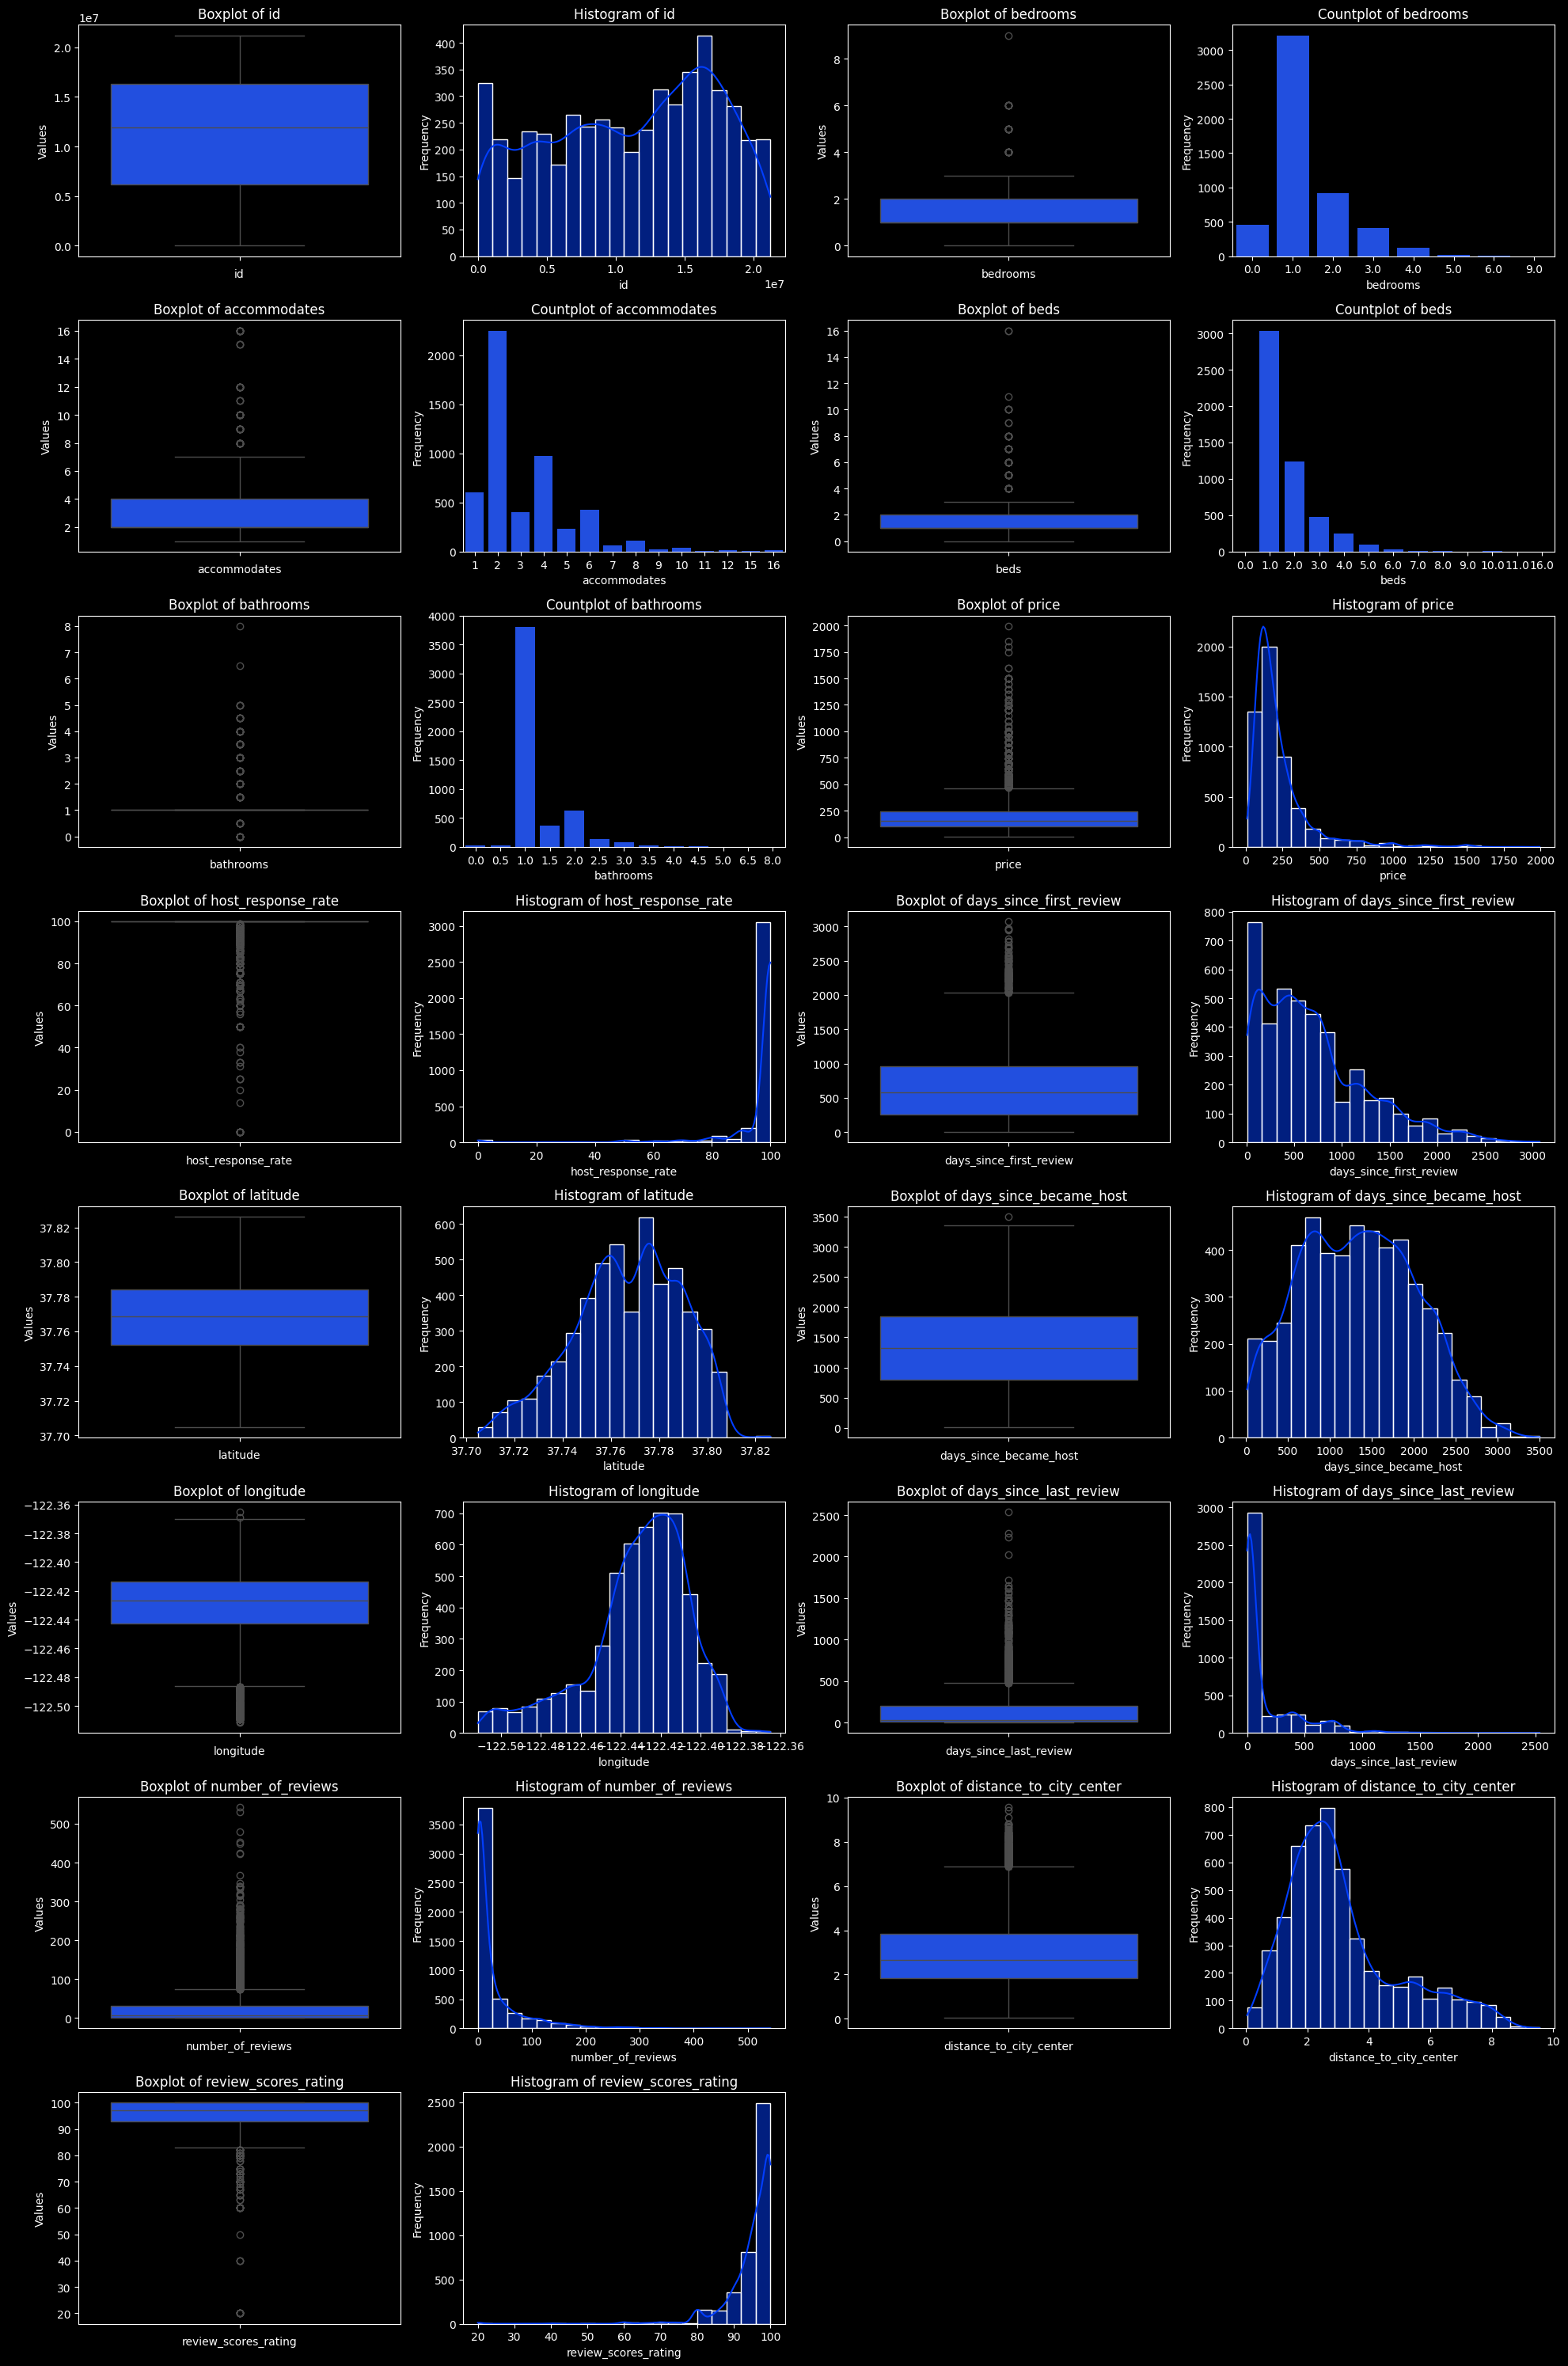

In [ ]:
numerical_cols = train.select_dtypes('number').columns
mid_point = (len(numerical_cols)+1)//2
# Membuat subplot
fig, axes = plt.subplots(mid_point, 4, figsize=(20, len(numerical_cols)*2))

for i, column in enumerate(numerical_cols):
  pos = 0 if i < mid_point else 2
  # Membuat boxplot untuk setiap fitur numerik
  sns.boxplot(train[column], ax=axes[i%mid_point, pos+0])
  axes[i%mid_point, pos+0].set_title(f'Boxplot of {column}')
  axes[i%mid_point, pos+0].set_xlabel(column)
  axes[i%mid_point, pos+0].set_ylabel('Values')
  # Membuat histogram untuk setiap fitur numerik
  if train[column].nunique() <= 20:
    sns.countplot(train, x=column, ax=axes[i%mid_point, pos+1])
    axes[i%mid_point, pos+1].set_title(f'Countplot of {column}')
    axes[i%mid_point, pos+1].set_xlabel(column)
    axes[i%mid_point, pos+1].set_ylabel('Frequency')
  else:
    sns.histplot(train[column], kde=True, ax=axes[i%mid_point, pos+1], bins=20)
    axes[i%mid_point, pos+1].set_title(f'Histogram of {column}')
    axes[i%mid_point, pos+1].set_xlabel(column)
    axes[i%mid_point, pos+1].set_ylabel('Frequency')

# Hapus bingkai yang tidak ada plotnya
for ax in fig.axes:
    if not ax.has_data():
        fig.delaxes(ax)

# Menampilkan plot
plt.tight_layout()
plt.show()

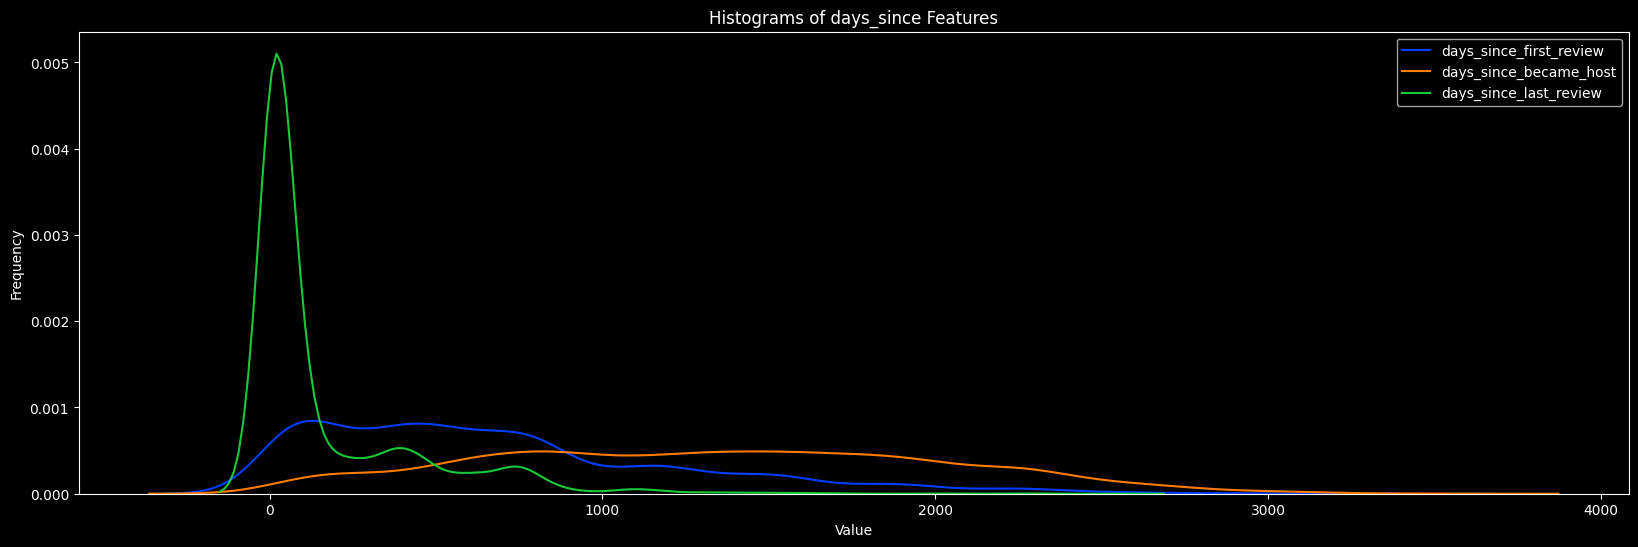

In [ ]:
# membandingkan tanggal
plt.figure(figsize=(20, 6))
sns.kdeplot(train['days_since_first_review'], label='days_since_first_review')
sns.kdeplot(train['days_since_became_host'], label='days_since_became_host')
sns.kdeplot(train['days_since_last_review'], label='days_since_last_review')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of days_since Features')
plt.legend(loc='best')
plt.show()

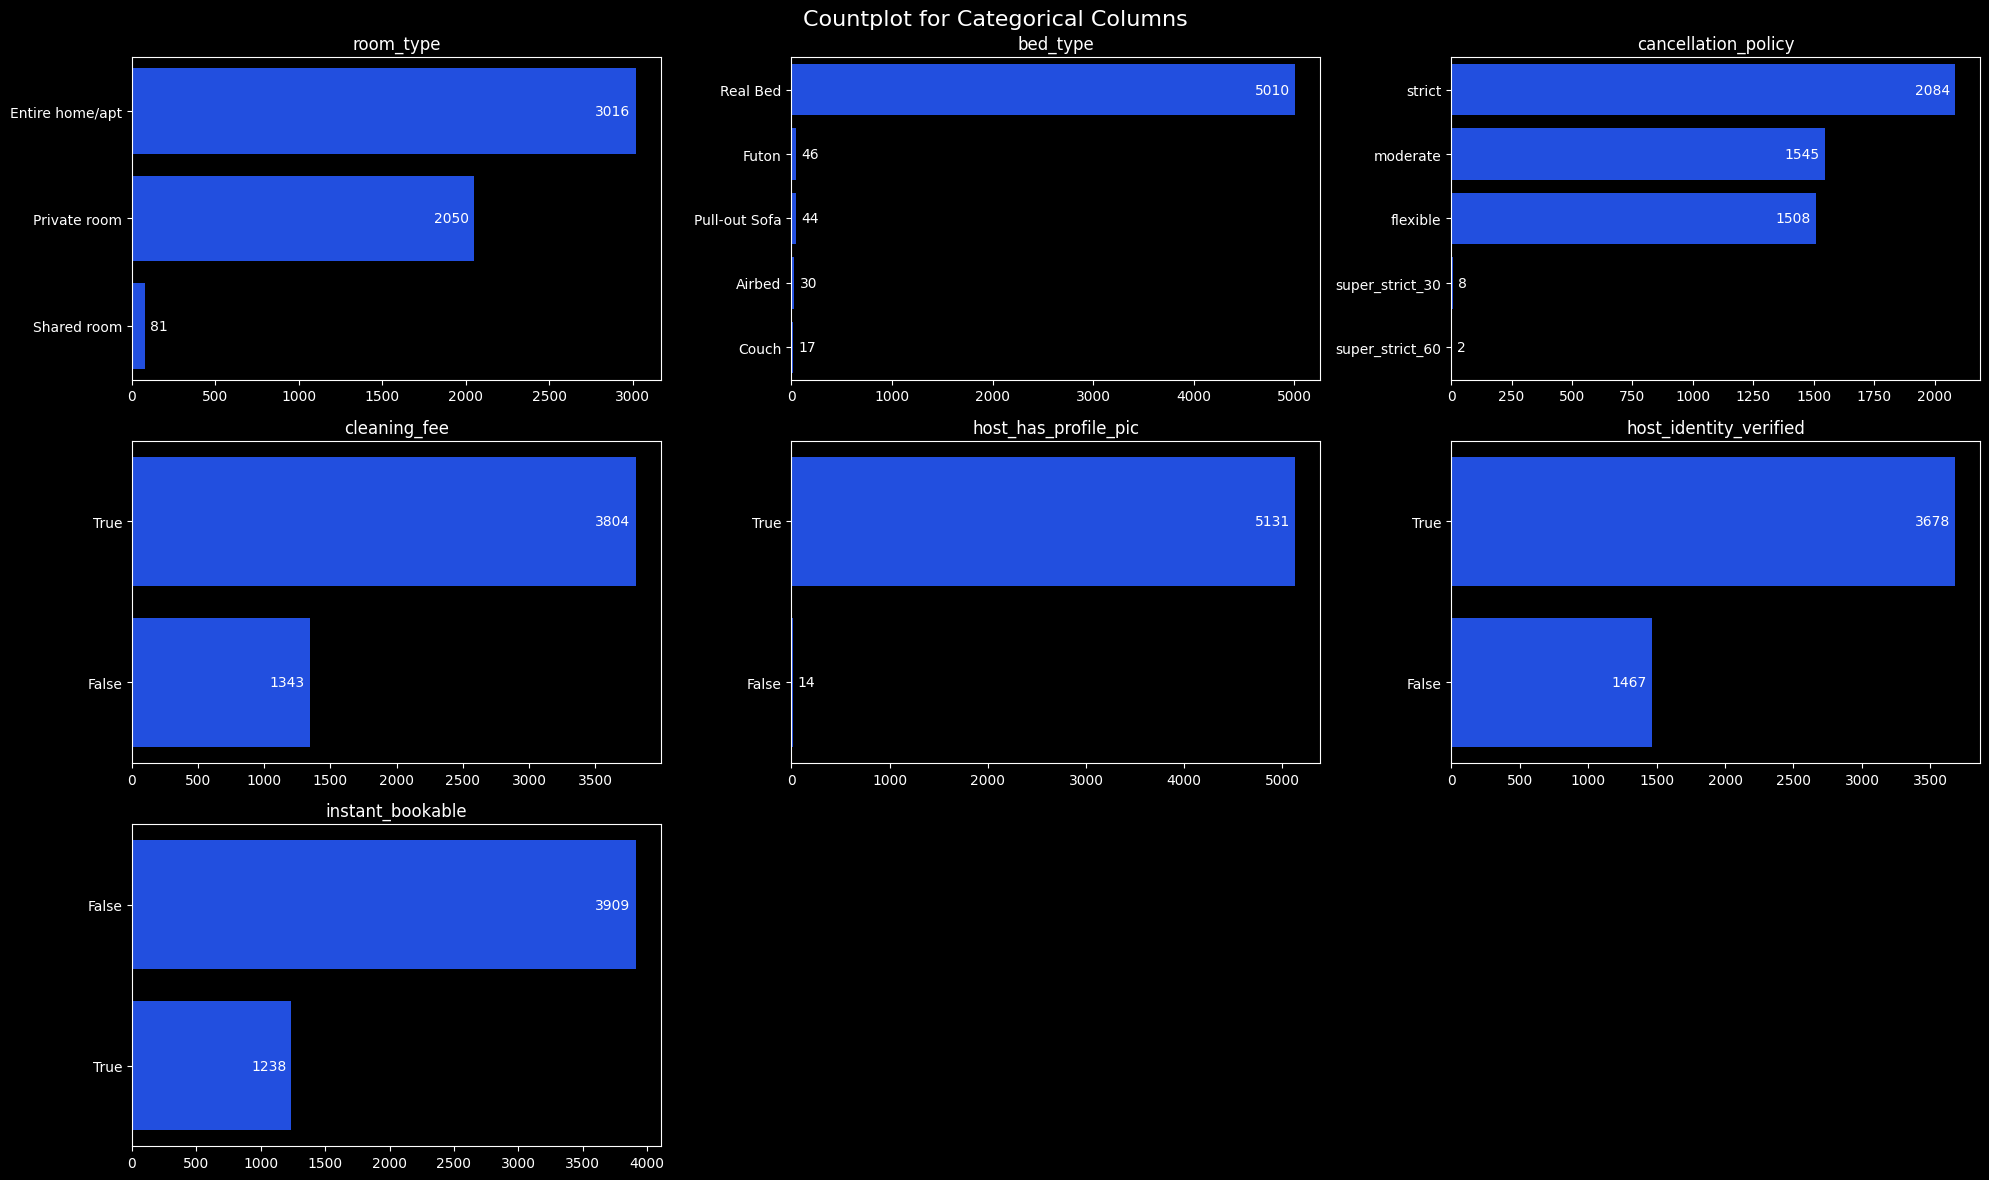

In [ ]:
cat_cols = train.select_dtypes(['category', 'bool']).columns
cat_cols = [col for col in cat_cols if train[col].nunique() <20]
third_point = (len(cat_cols)+2)//3

# Mengatur ukuran figure dan layout grid
fig, axes = plt.subplots(third_point, 3, figsize=(20, 4*third_point))
fig.suptitle('Countplot for Categorical Columns', fontsize=16)

# Flatten axes agar bisa iterasi dengan mudah
axes = axes.flatten()

# Membuat countplot untuk setiap fitur
for i, col in enumerate(cat_cols):
  order = train[col].value_counts().index
  sns.countplot(train, y=col, order=order, ax=axes[i])
  axes[i].set_title(col)
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

  # Menambahkan label nilai di setiap bar
  for j, bar in enumerate(axes[i].patches):
    count = int(bar.get_width())
    bar_height = bar.get_height()
    max_count = count if j == 0 else max_count

    if count > max_count/10: # label di dalam bar jika bar panjang
      axes[i].text(count - max_count/100, bar.get_y() + bar_height / 2, str(count), va='center', ha='right', color='white', fontsize=10)
    else: # di luar bar jika bar pendek
      axes[i].text(count + max_count/100, bar.get_y() + bar_height / 2, str(count), va='center', ha='left', fontsize=10)

# Hapus bingkai yang tidak ada plotnya
for ax in fig.axes:
    if not ax.has_data():
        fig.delaxes(ax)

plt.tight_layout() # Mengatur layout dan spasi
plt.show()

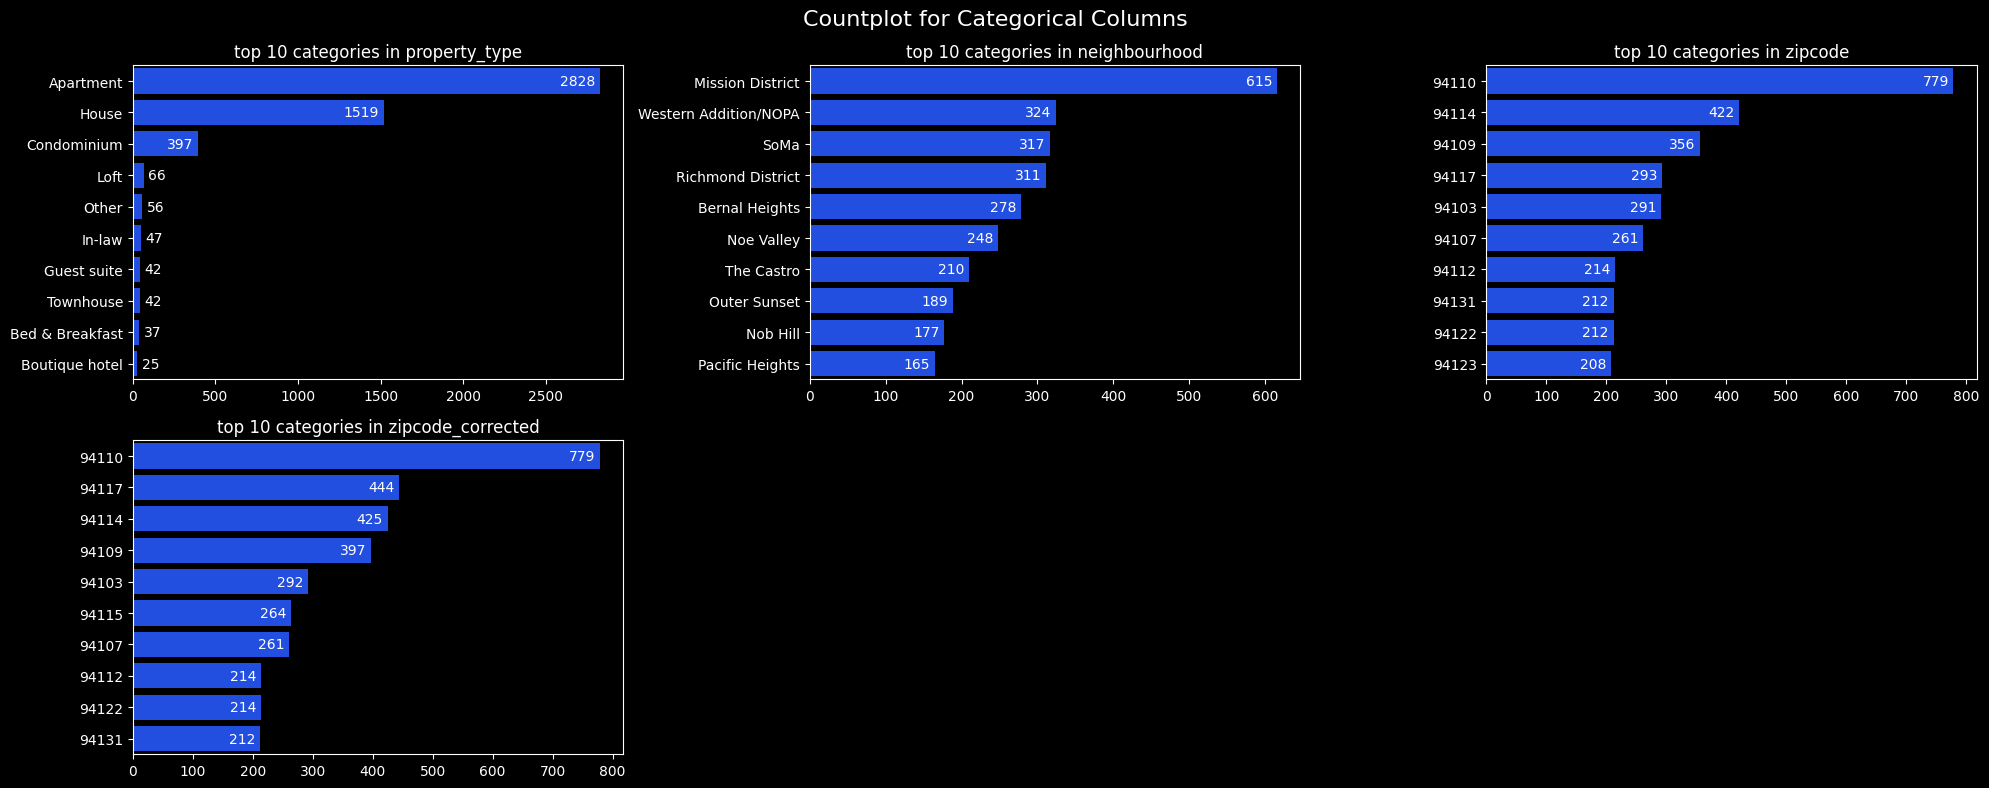

In [ ]:
cardinal_col = train.select_dtypes('category').columns
cardinal_col = [col for col in cardinal_col if 20<train[col].nunique()<1000]
third_point = (len(cardinal_col)+2)//3

# Mengatur ukuran figure dan layout grid
fig, axes = plt.subplots(third_point, 3, figsize=(20, 4*third_point))
fig.suptitle('Countplot for Categorical Columns', fontsize=16)

# Flatten axes agar bisa iterasi dengan mudah
axes = axes.flatten()

# Membuat countplot untuk setiap fitur
for i, col in enumerate(cardinal_col):
  # assume 'categories' is the column with categorical data
  top_10_categories = train[col].value_counts().iloc[:10].index

  sns.countplot(y=col, data=train, order=top_10_categories, ax=axes[i])
  axes[i].set_title(f"top 10 categories in {col}")
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

  # Menambahkan label nilai di setiap bar
  for j, bar in enumerate(axes[i].patches):
    count = int(bar.get_width())
    bar_height = bar.get_height()
    max_count = count if j == 0 else max_count

    if count > max_count/10: # label di dalam bar jika bar panjang
      axes[i].text(count - max_count/100, bar.get_y() + bar_height / 2, str(count), va='center', ha='right', color='white', fontsize=10)
    else: # di luar bar jika bar pendek
      axes[i].text(count + max_count/100, bar.get_y() + bar_height / 2, str(count), va='center', ha='left', fontsize=10)


# Hapus bingkai yang tidak ada plotnya
for ax in fig.axes:
    if not ax.has_data():
        fig.delaxes(ax)

plt.tight_layout() # Mengatur layout dan spasi
plt.show()

## Analisis Bivariat

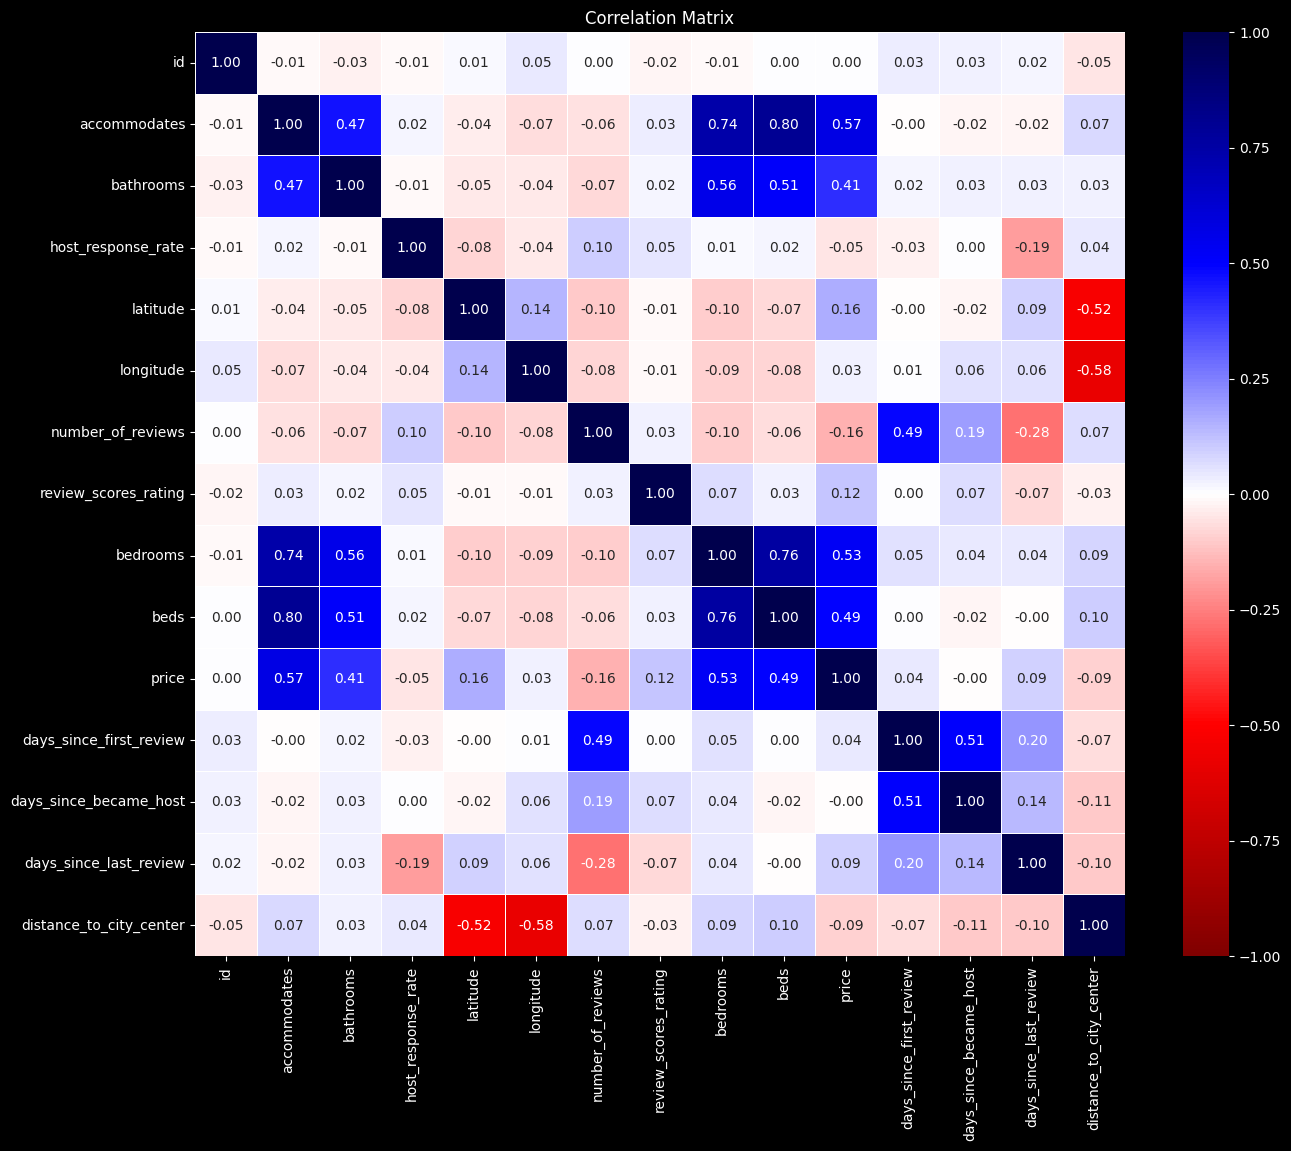

In [ ]:
numerical_cols = train.select_dtypes('number').columns.to_list()

# Menghitung korelasi dengan kolom 'Churn'
correlation_matrix = train[numerical_cols].corr()

# Menampilkan korelasi dalam bentuk heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic_r', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
numerical_cols = train.select_dtypes('number').columns.to_list()

# Membuat pairplot untuk kolom numerik dan target
sns.pairplot(train[numerical_cols], kind='scatter', corner=True)
plt.suptitle('Pairplot of Numeric Columns', y=1.02)

# Menampilkan plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

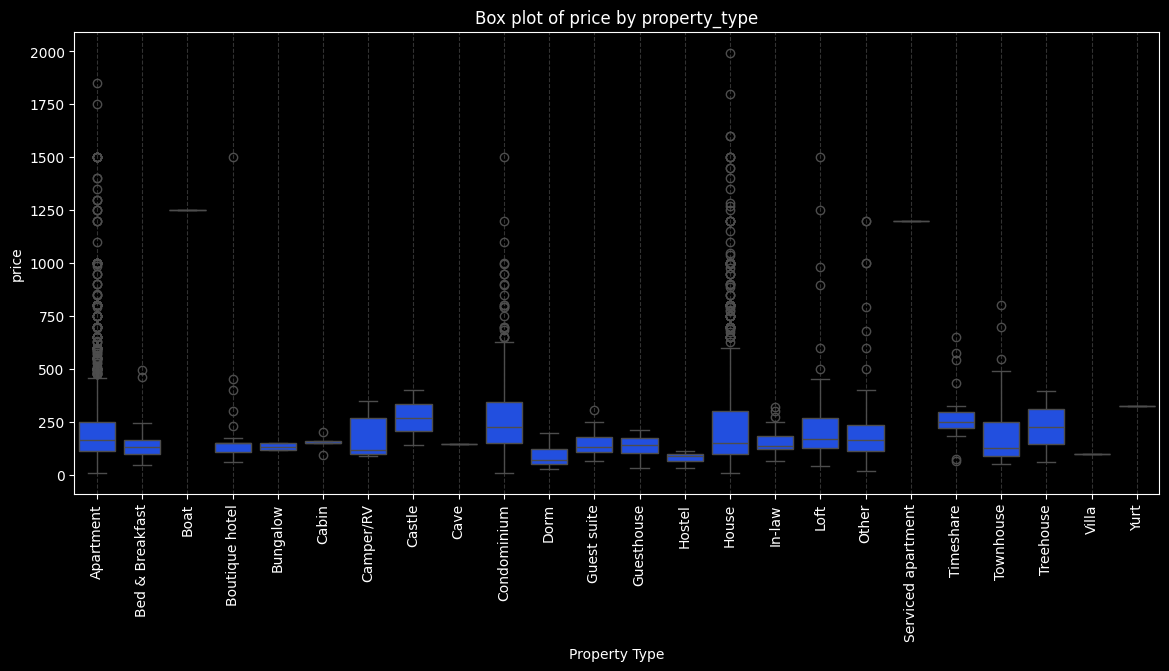

In [ ]:
# Average price by property_type
property_type_avg_price = train.groupby('property_type')['price'].mean().reset_index()

# Box plot for property_type vs price
plt.figure(figsize=(14, 6))
sns.boxplot(x='property_type', y='price', data=train)
plt.title('Box plot of price by property_type')
plt.xlabel('Property Type')
plt.ylabel('price')
plt.xticks(rotation=90)
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.show()

In [ ]:
# 2 properti ini harganya beda jauh, tapi karena jumlah datanya sedikit, jadi tidak bisa digeneralisir
train[(train['property_type'] == 'Boat') | (train['property_type'] == 'Serviced apartment')].head(50)

id       property_type        room_type  \
23392  16867947  Serviced apartment  Entire home/apt   
21883   4916065                Boat     Private room   

                                               amenities  accommodates  \
23392  {TV,"Wireless Internet","Air conditioning",Kit...             4   
21883  {TV,"Air conditioning",Kitchen,Breakfast,Heati...             4   

       bathrooms  bed_type cancellation_policy  cleaning_fee  \
23392        1.5  Real Bed              strict         False   
21883        1.0  Real Bed            flexible         False   

                                             description first_review  \
23392  1 Bedroom Condo Includes: 1 King Master Suite ...   2017-02-15   
21883  Private yacht for 4 Passengers 2 state rooms a...          NaT   

      host_has_profile_pic host_identity_verified  host_response_rate  \
23392                 True                   True                80.0   
21883                 True                  False                 NaN   

      host_since  instant_bookable last_review   latitude   longitude  \
23392 2015-08-30             False  2017-02-15  37.788941 -122.402212   
21883 2014-09-27             False         NaT  37.796715 -122.394870   

                                           name       neighbourhood  \
23392  1BR San Francisco Ritz Carlton Residence  Financial District   
21883          Private yacht for 4 Sleep over 4  Financial District   

       number_of_reviews  review_scores_rating  \
23392                  1                 100.0   
21883                  0                   NaN   

                                           thumbnail_url zipcode  bedrooms  \
23392  https://a0.muscache.com/im/pictures/63a16d9d-5...   94104       1.0   
21883                                                NaN   94105       1.0   

       beds   price zipcode_corrected  days_since_first_review  \
23392   1.0  1199.0             94104                    228.0   
21883   3.0  1249.0             94105                      NaN   

       days_since_became_host  days_since_last_review  \
23392                   763.0                   228.0   
21883                  1100.0                     NaN   

       distance_to_city_center           neighbourhood_grouped  
23392                 2.172849  Downtown & Central Attractions  
21883                 3.245229  Downtown & Central Attractions

In [ ]:
# mengurangi kardinalitas pada fitur property type, value yang jarang muncul dijadikan 1
def categorize_property(property_type):
  property_type = property_type.lower() # ubah ke lowercase
  return property_type if property_type in {"apartment", "house", "condominium"} else "others"

# terapkan ke kolom property_type
train["property_type_grouped"] = train["property_type"].apply(categorize_property)

train['property_type_grouped'].value_counts()

property_type_grouped
apartment      2828
house          1519
others          403
condominium     397
Name: count, dtype: int64

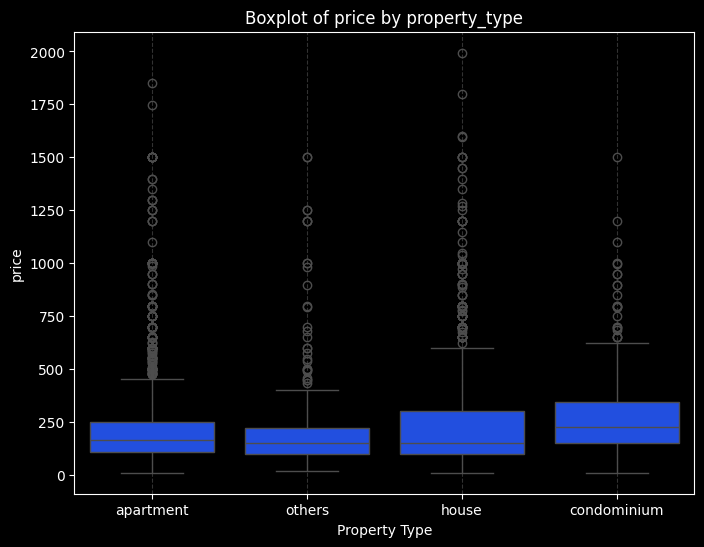

In [ ]:
# Average price by property_type
property_type_avg_price = train.groupby('property_type_grouped')['price'].mean().reset_index()

# Boxplot for property_type_grouped vs price
plt.figure(figsize=(8, 6))
sns.boxplot(x='property_type_grouped', y='price', data=train)
plt.title('Boxplot of price by property_type')
plt.xlabel('Property Type')
plt.ylabel('price')
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.show()

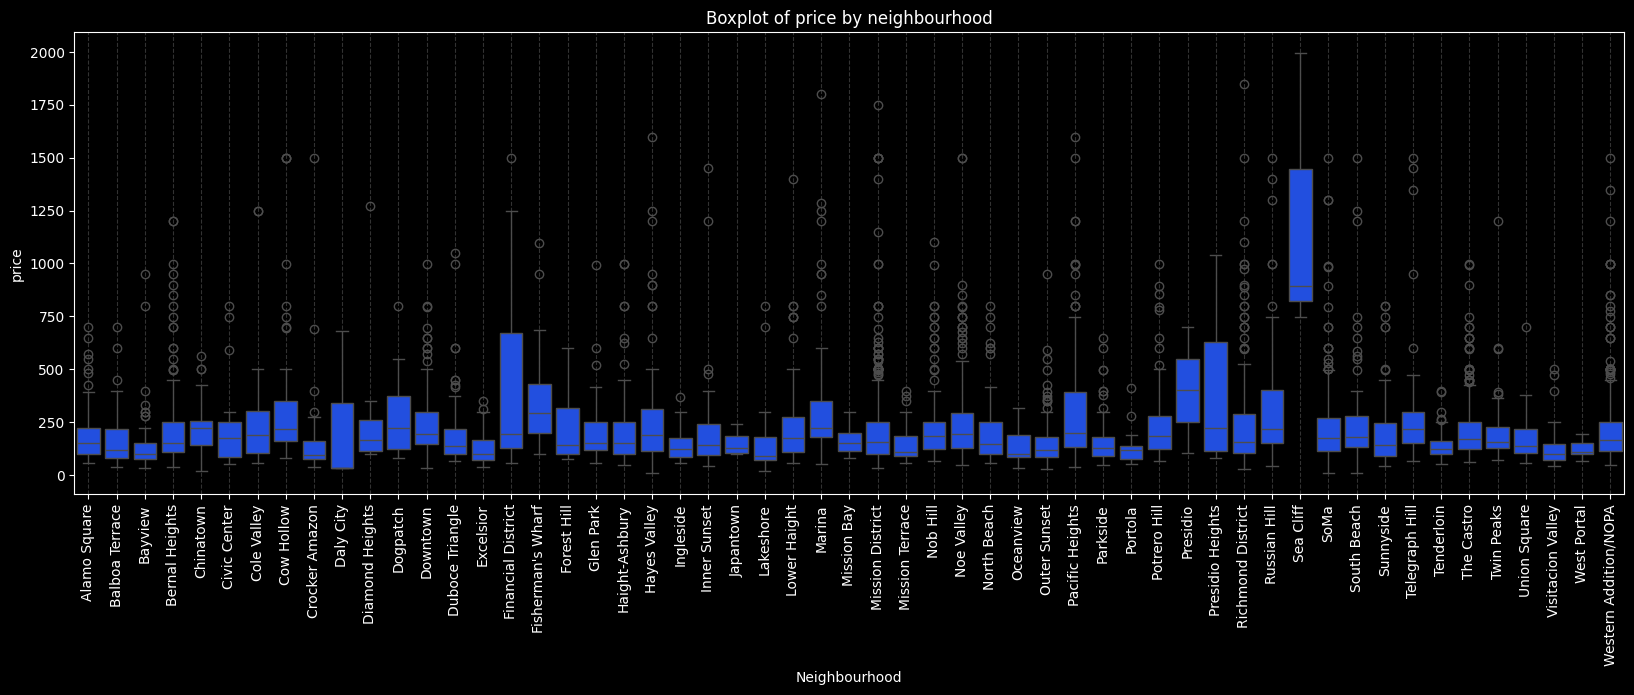

In [ ]:
# Average price by neighbourhood
neighbourhood_avg_price = train.groupby('neighbourhood')['price'].mean().reset_index()

# Boxplot for neighbourhood vs price
plt.figure(figsize=(20, 6))
sns.boxplot(x='neighbourhood', y='price', data=train)
plt.title('Boxplot of price by neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('price')
plt.xticks(rotation=90)
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.show()

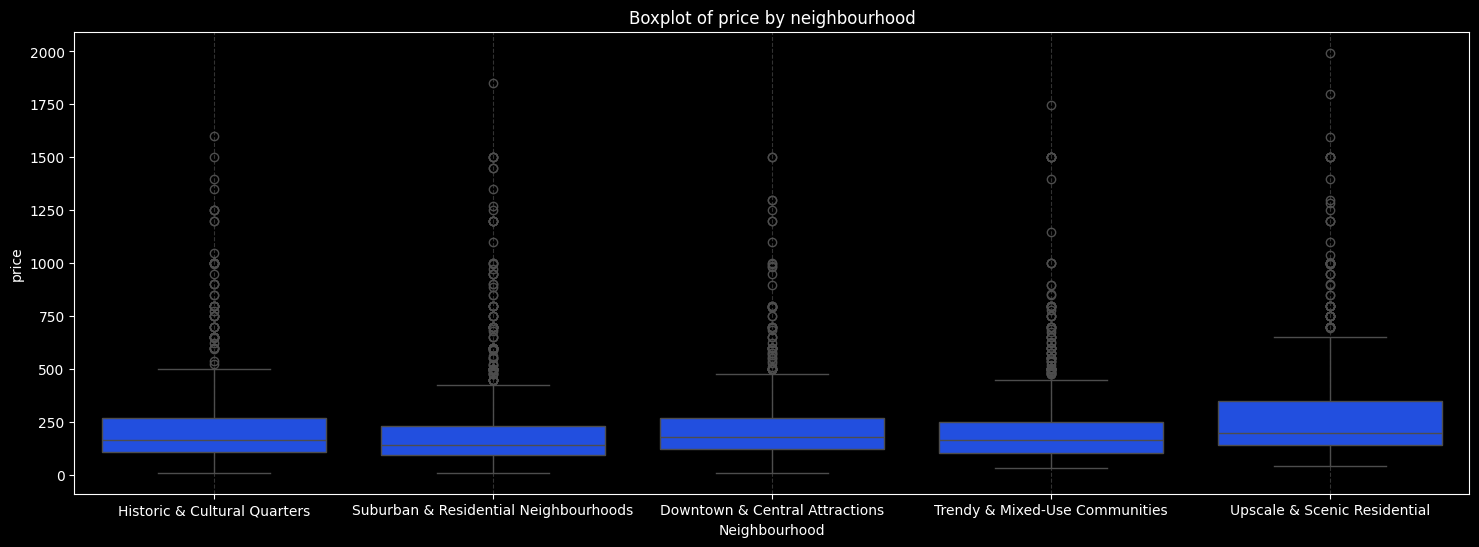

In [ ]:
# Average price by neighbourhood
neighbourhood_avg_price = train.groupby('neighbourhood_grouped')['price'].mean().reset_index()

# Boxplot for neighbourhood_grouped vs price
plt.figure(figsize=(18, 6))
sns.boxplot(x='neighbourhood_grouped', y='price', data=train)
plt.title('Boxplot of price by neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('price')
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.show()

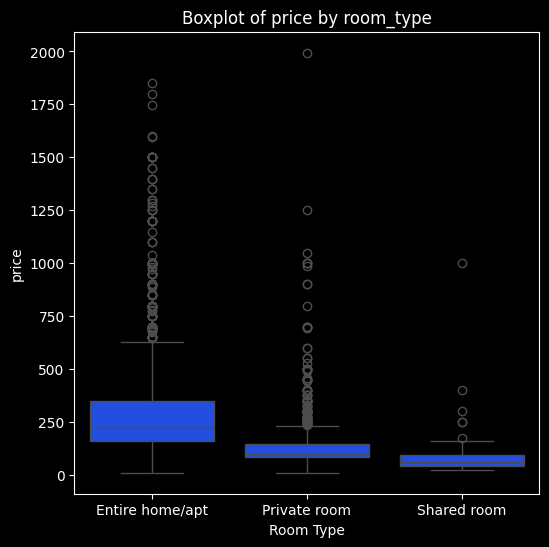

In [ ]:
# Boxplot for room type vs price
plt.figure(figsize=(6, 6))
sns.boxplot(x='room_type', y='price', data=train)
plt.title('Boxplot of price by room_type')
plt.xlabel('Room Type')
plt.ylabel('price')
plt.show()

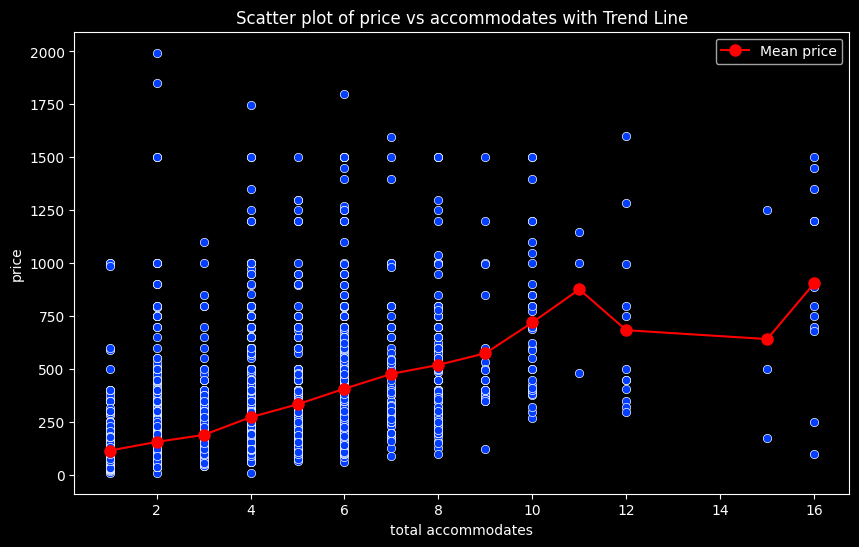

In [ ]:
# Calculate mean price for each value of accommodates
mean_price = train.groupby('accommodates')['price'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='accommodates', y='price', data=train)
plt.plot(mean_price.index, mean_price.values, color='red', linestyle='-', marker='o', markersize=8, label='Mean price')
plt.title('Scatter plot of price vs accommodates with Trend Line')
plt.xlabel('total accommodates')
plt.ylabel('price')
plt.legend()
plt.show()

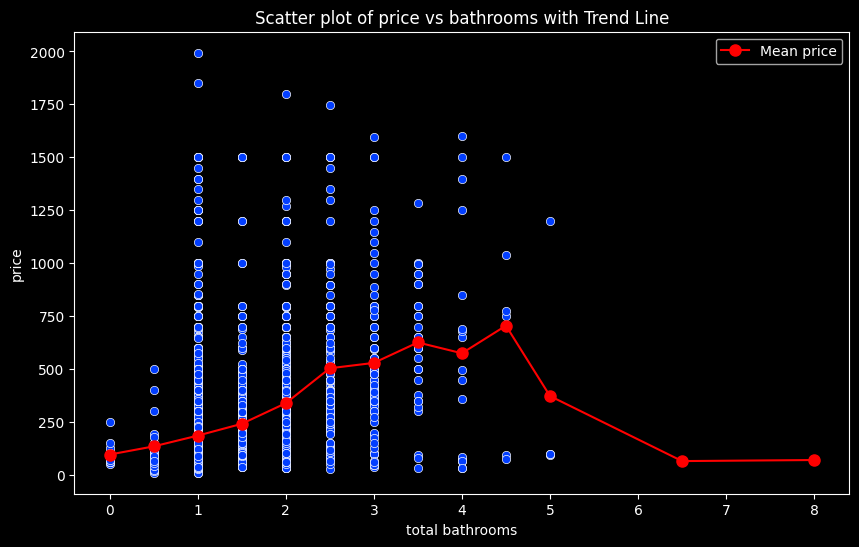

In [ ]:
# Calculate mean price for each value of accommodates
mean_price = train.groupby('bathrooms')['price'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bathrooms', y='price', data=train)
plt.plot(mean_price.index, mean_price.values, color='red', linestyle='-', marker='o', markersize=8, label='Mean price')
plt.title('Scatter plot of price vs bathrooms with Trend Line')
plt.xlabel('total bathrooms')
plt.ylabel('price')
plt.legend()
plt.show()

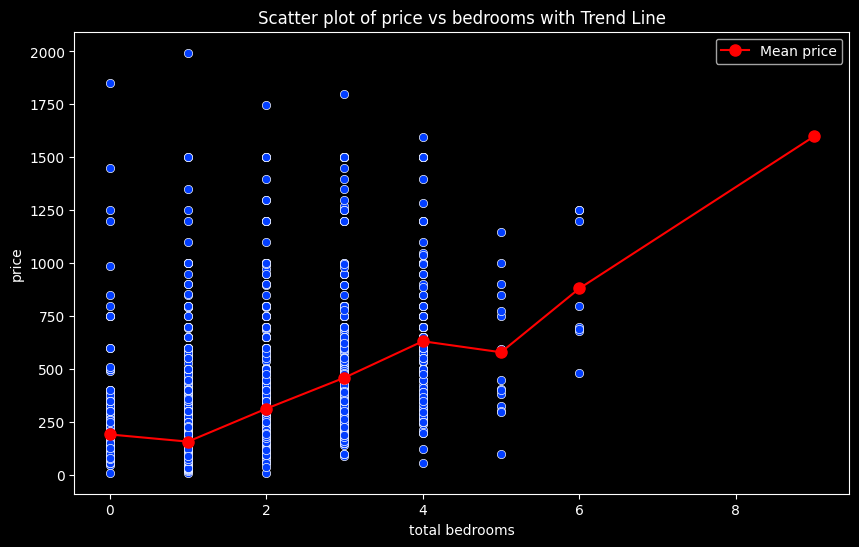

In [ ]:
# Calculate mean price for each value of accommodates
mean_price = train.groupby('bedrooms')['price'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=train)
plt.plot(mean_price.index, mean_price.values, color='red', linestyle='-', marker='o', markersize=8, label='Mean price')
plt.title('Scatter plot of price vs bedrooms with Trend Line')
plt.xlabel('total bedrooms')
plt.ylabel('price')
plt.legend()
plt.show()

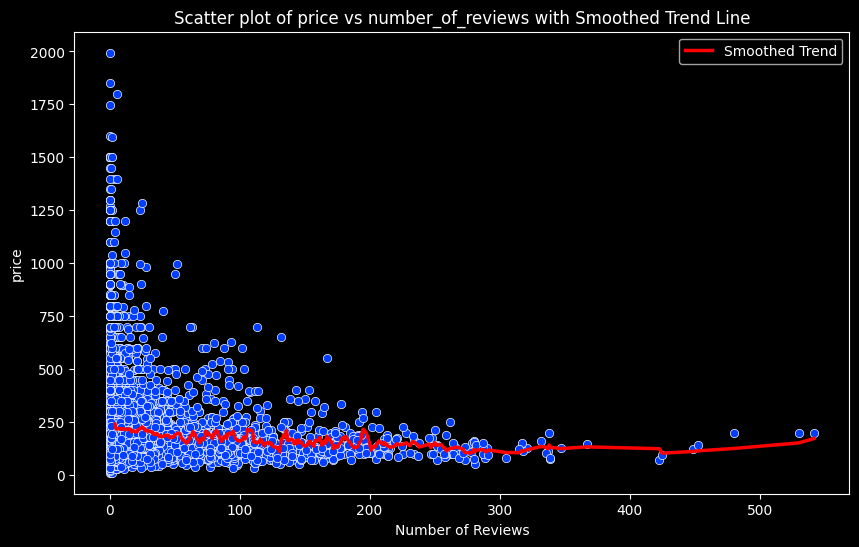

In [ ]:
#calculating the rolling mean of price to smoothen the trend line
rolling_mean_price = train.groupby('number_of_reviews')['price'].mean().rolling(window=5).mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='price', data=train)
plt.plot(rolling_mean_price.index, rolling_mean_price.values, color='red', linestyle='-', label='Smoothed Trend', linewidth=2.5)
plt.title('Scatter plot of price vs number_of_reviews with Smoothed Trend Line')
plt.xlabel('Number of Reviews')
plt.ylabel('price')
plt.legend()
plt.show()

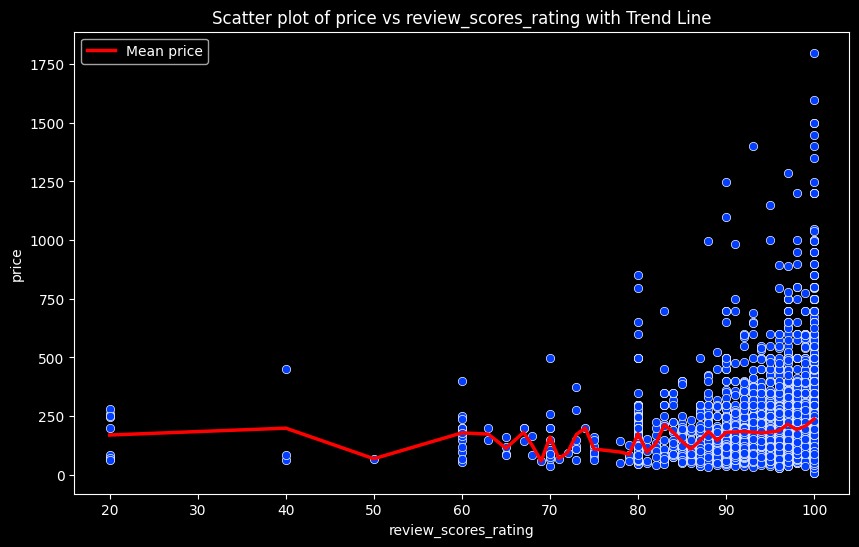

In [ ]:
# Calculate mean price for each value of review_scores_rating
mean_price = train.groupby('review_scores_rating')['price'].mean().rolling(window=1).mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating', y='price', data=train)
plt.plot(mean_price.index, mean_price.values, color='red', linestyle='-', markersize=8, label='Mean price', linewidth=2.5)
plt.title('Scatter plot of price vs review_scores_rating with Trend Line')
plt.xlabel('review_scores_rating')
plt.ylabel('price')
plt.legend()
plt.show()

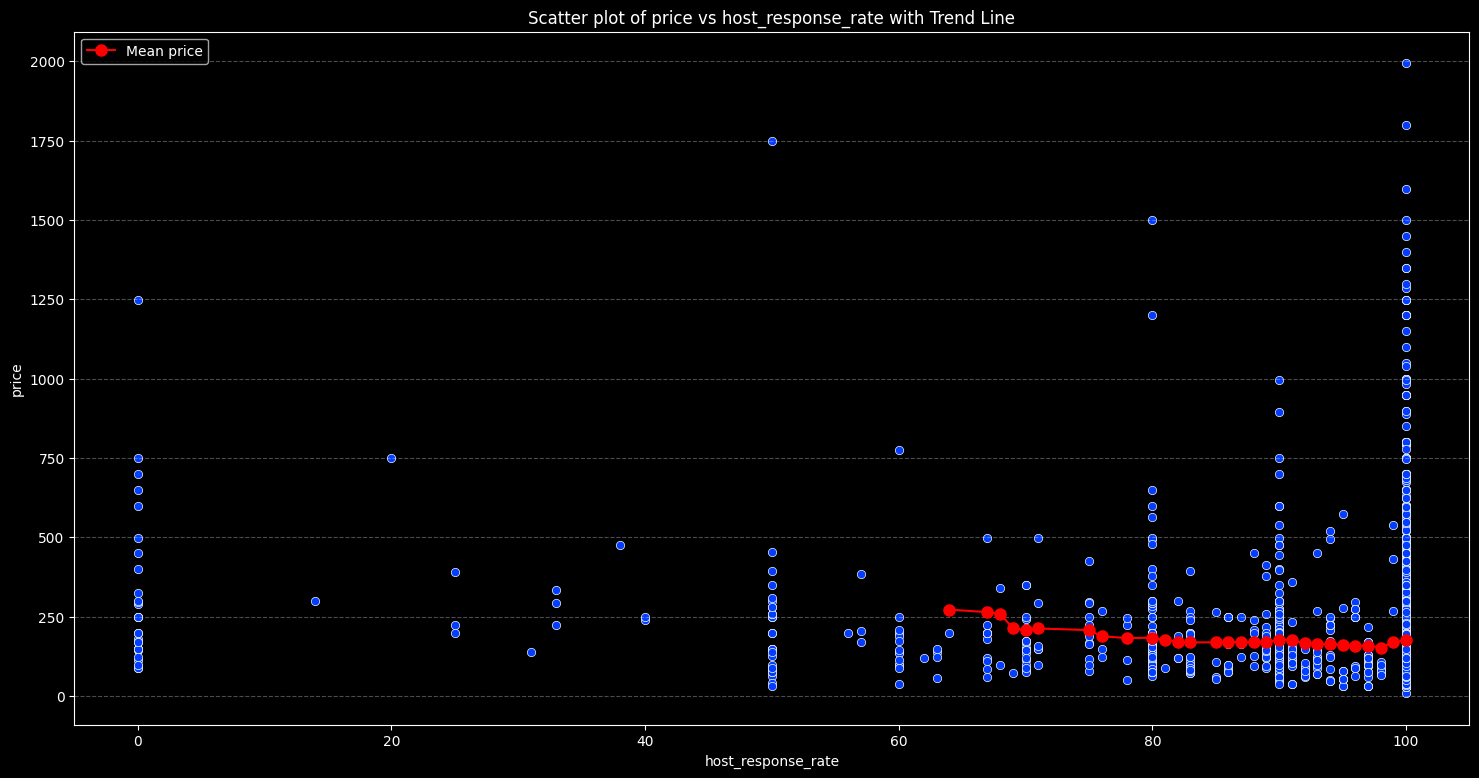

In [ ]:
mean_price = train.groupby('host_response_rate')['price'].mean().rolling(window=15).mean()

plt.figure(figsize=(18,9))
sns.scatterplot(x='host_response_rate', y='price', data=train)
plt.plot(mean_price.index, mean_price.values, color='red', linestyle='-', marker='o', markersize=8, label='Mean price')
plt.title('Scatter plot of price vs host_response_rate with Trend Line')
plt.xlabel('host_response_rate')
plt.ylabel('price')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.show()

## Explore Amenities

In [ ]:
# one hot encoding kolom amenities

# fungsi untuk mengambil fasilitas dari string berbentuk set
def extract_amenities(amenities_str, pattern):
  matches = re.findall(pattern, amenities_str.lower())  # ubah ke lowercase
  return {match[0] or match[1] for match in matches}  # pakai set agar unik

# untuk membersihkan dan menyamakan fasilitas
amenity_mapping = {
  "wifi": {"wireless internet", "internet", "pocket wifi"},
  "tv": {"tv", "cable tv"},
  "washer": {"washer", "washer / dryer"},
  "dryer": {"dryer", "washer / dryer"},
  "bathtub": {"bathtub", "bathtub with shower chair"},
  "shower": {"handheld shower head", "shower"},
  "shower chair": {"bathtub with shower chair", "roll-in shower with chair"},
  "roll-in shower": {"roll-in shower with chair"},
  "fireplace": {"indoor fireplace", "fireplace guards"},
  "hot water kettle": {"hot water kettle", "kettle"},
  "babysitter": {"baby monitor", "babysitter recommendations"},
  "pet-friendly": {"pets allowed", "pets live on this property", "cat", "dog", "other pet(s)"},
  # "flat and smooth pathway to front door": {'flat, smooth pathway to front door', 'flat smooth pathway to front door'} # kebetulan di data train san fransisco random state=42 tidak ada
}

invalid_values = {"s", "translation missing: en.hosting_amenity_49", "translation missing: en.hosting_amenity_50"}

# fungsi untuk membersihkan daftar fasilitas
def clean_amenities(amenities):
  cleaned = set()
  for amenity in amenities:
    if amenity in invalid_values:
      continue  # abaikan nilai tidak valid
    found = False
    for standard, variations in amenity_mapping.items():
      if amenity in variations:
        cleaned.add(standard)  # gunakan versi standar
        found = True
        break
    if not found:
      cleaned.add(amenity)  # tetap tambahkan jika tidak perlu normalisasi
  return cleaned

# pola regex untuk mencocokkan item dalam tanda kutip atau kata-kata tanpa kutip
pattern = r'(\w+)|"(.*?)"'

# ekstrak dan bersihkan semua fasilitas unik
amenities = set()
train['amenities'].apply(lambda x: amenities.update(clean_amenities(extract_amenities(x, pattern))))

# konversi ke list agar urut
amenities = sorted(amenities)

# membuat fitur dummy
for amenity in amenities:
  train[f"has_{amenity.replace(' ', '_')}"] = train['amenities'].apply(lambda x: amenity in clean_amenities(extract_amenities(x, pattern)))

print(len(amenities)) # total jumlah fasilitas yang tersedia
for i, amenity in enumerate(amenities):
  print(amenity, end='; ')
  if i % 7 == 6:
    print()

101
24-hour check-in; accessible-height bed; accessible-height toilet; air conditioning; baby bath; babysitter; bathtub; 
bbq grill; beach essentials; beachfront; bed linens; breakfast; buzzer/wireless intercom; carbon monoxide detector; 
changing table; children’s books and toys; children’s dinnerware; cleaning before checkout; coffee maker; cooking basics; crib; 
disabled parking spot; dishes and silverware; dishwasher; doorman; dryer; elevator; essentials; 
ethernet connection; ev charger; extra pillows and blankets; family/kid friendly; fire extinguisher; fireplace; firm mattress; 
first aid kit; fixed grab bars for shower & toilet; flat, smooth pathway to front door; free parking on premises; free parking on street; game console; garden or backyard; 
ground floor access; gym; hair dryer; hangers; heating; high chair; host greets you; 
hot tub; hot water; hot water kettle; iron; keypad; kitchen; lake access; 
laptop friendly workspace; lock on bedroom door; lockbox; long term stays

Text(0, 0.5, 'Frequeny')

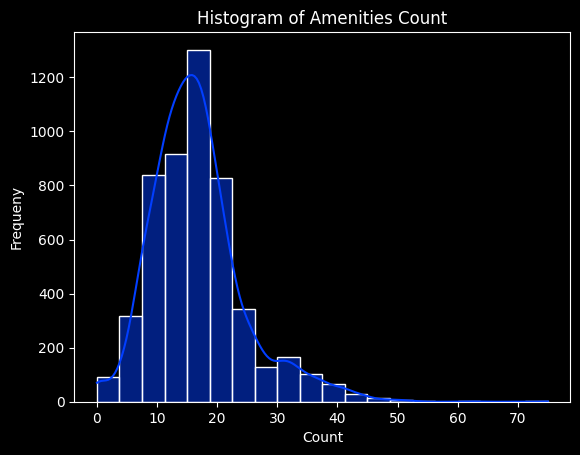

In [ ]:
# buat fitur baru: jumlah fasilitas
amenity_cols = [col for col in train.columns if col.startswith('has_')]
train['amen_count'] = train[amenity_cols].sum(axis=1)

ax = sns.histplot(train['amen_count'], kde=True, bins=20)
plt.title("Histogram of Amenities Count")
plt.xlabel("Count")
plt.ylabel("Frequeny")

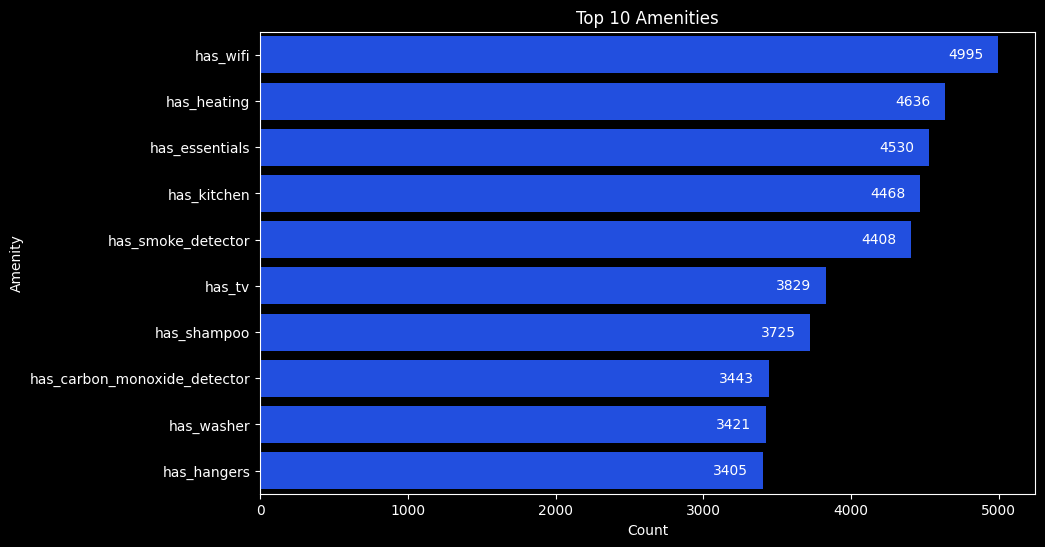

In [ ]:
# 10 fasilitas paling sering disediakan
amenities_counts = train[amenity_cols].sum()
amenities_counts = pd.DataFrame(amenities_counts, columns=['count'])
top_10_amenities = amenities_counts.sort_values(by='count', ascending=False).iloc[:10].reset_index()

# Creating the countplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='count', y='index', data=top_10_amenities)

plt.title("Top 10 Amenities")
plt.xlabel("Count")
plt.ylabel("Amenity")

# Menambahkan label nilai di setiap bar
for bar in ax.patches:
  count = int(bar.get_width())
  bar_height = bar.get_height()

  ax.text(count - 100, bar.get_y() + bar_height / 2, str(count), va='center', ha='right', color='white', fontsize=10)

plt.show()

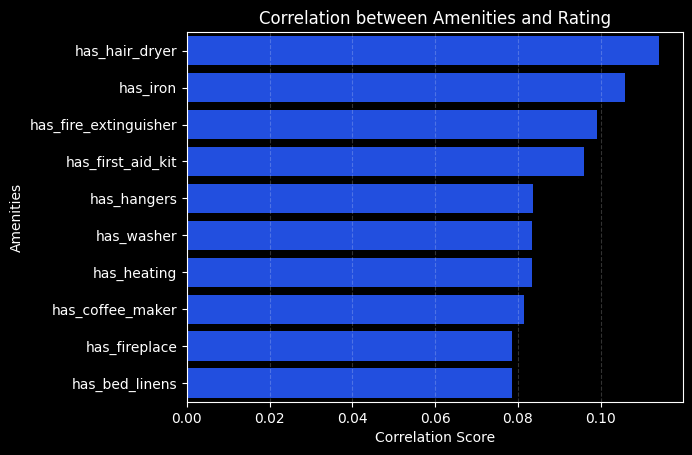

In [ ]:
# 10 fasilitas paling berkorelasi terhadap rating
correlation_results = []

for amenity in amenity_cols:
  # hilangkan baris yang mengandung NaN pada kedua kolom yang dianalisis
  exist_data = train[[amenity, 'review_scores_rating']].dropna()

  # Loop untuk menghitung korelasi untuk setiap kolom fasilitas
  if not exist_data.empty:
    corr, p_value = pointbiserialr(exist_data[amenity], exist_data['review_scores_rating'])
    correlation_results.append({'nama_fitur': amenity, 'nilai_korelasi': corr, 'p_value': p_value})
  else:
    correlation_results.append({'nama_fitur': amenity, 'nilai_korelasi': None, 'p_value': None})

# Membuat dataframe untuk menampilkan hasil
correlation_table = pd.DataFrame(correlation_results)

# Mengurutkan hasil berdasarkan nilai korelasi tertinggi
correlation_table = correlation_table.sort_values(by='nilai_korelasi', ascending=False)

# Filter untuk menghapus fitur dengan p-value > 0.05
filtered_table = correlation_table[(correlation_table['p_value'] <= 0.05)]

# Mengurutkan berdasarkan nilai absolut korelasi
filtered_table = filtered_table.reindex(filtered_table['nilai_korelasi'].abs().sort_values(ascending=False).index)

# Menampilkan hasil 10 amenities teratas
# Buat barchart menggunakan seaborn
sns.barplot(data=filtered_table.iloc[:10], x='nilai_korelasi', y='nama_fitur')
plt.xlabel('Correlation Score')
plt.ylabel('Amenities')
plt.title('Correlation between Amenities and Rating')

# Tampilkan grid horizontal untuk memperjelas perbedaan nilai
plt.grid(axis='x', linestyle='--', alpha=0.2)

# Tampilkan plot
plt.show()

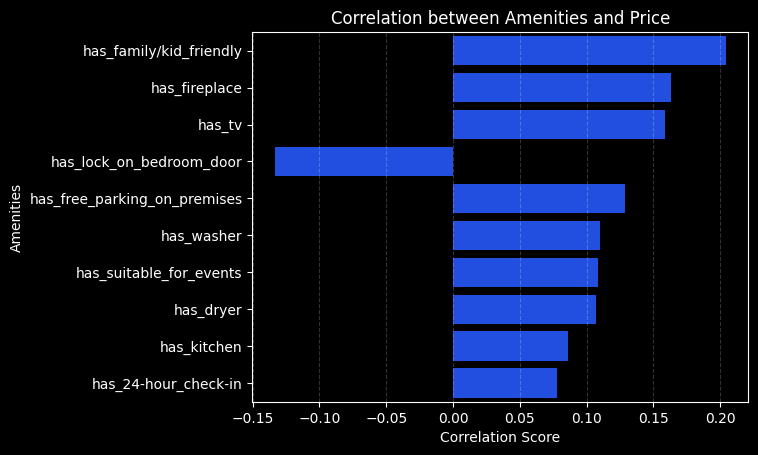

In [ ]:
# 10 fasilitas paling berkorelasi terhadap harga
correlation_results = []

# Loop untuk menghitung korelasi untuk setiap kolom fasilitas
for amenity in amenity_cols:
    corr, p_value = pointbiserialr(train[amenity], train['price'])
    correlation_results.append({'nama_fitur': amenity, 'nilai_korelasi': corr, 'p_value': p_value})

# Membuat dataframe untuk menampilkan hasil
correlation_table = pd.DataFrame(correlation_results)

# Mengurutkan hasil berdasarkan nilai korelasi tertinggi
correlation_table = correlation_table.sort_values(by='nilai_korelasi', ascending=False)

# Filter untuk menghapus fitur dengan p-value > 0.05
filtered_table = correlation_table[(correlation_table['p_value'] <= 0.05)]

# Mengurutkan berdasarkan nilai absolut korelasi
filtered_table = filtered_table.reindex(filtered_table['nilai_korelasi'].abs().sort_values(ascending=False).index)

# Menampilkan hasil 10 amenities teratas
# Buat barchart menggunakan seaborn
sns.barplot(data=filtered_table.iloc[:10], x='nilai_korelasi', y='nama_fitur')
plt.xlabel('Correlation Score')
plt.ylabel('Amenities')
plt.title('Correlation between Amenities and Price')

# Tampilkan grid horizontal untuk memperjelas perbedaan nilai
plt.grid(axis='x', linestyle='--', alpha=0.2)

# Tampilkan plot
plt.show()

In [ ]:
# buat fitur baru: jumlah fasilitas yang paling signifikan dalam mempengaruhi harga
refiltered_table = filtered_table[(filtered_table['nilai_korelasi'] >= 0.1) | (filtered_table['nilai_korelasi'] <= -0.1)]
filtered_amenities = refiltered_table['nama_fitur'].tolist()
train['filtered_amen_count'] = train[filtered_amenities].sum(axis=1)
train

id property_type        room_type  \
11184   7696527     Apartment  Entire home/apt   
9932    4445915     Apartment     Private room   
68086  11282208     Timeshare  Entire home/apt   
23239   5353533     Apartment  Entire home/apt   
68512  16120533         House  Entire home/apt   
...         ...           ...              ...   
43041  10553960     Apartment  Entire home/apt   
59701   4136914     Apartment     Private room   
60212   6170405     Apartment     Private room   
61945  14443358     Apartment  Entire home/apt   
9268    3207986     Apartment     Private room   

                                               amenities  accommodates  \
11184  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             2   
9932   {TV,"Wireless Internet","Smoke detector","Carb...             1   
68086  {TV,"Cable TV",Internet,"Wireless Internet","A...             4   
23239  {TV,"Cable TV","Wireless Internet",Kitchen,"Fr...             5   
68512  {Internet,"Wireless Internet",Kitchen,"Pets li...             7   
...                                                  ...           ...   
43041  {Internet,"Wireless Internet",Kitchen,"Free pa...             3   
59701  {TV,Internet,"Wireless Internet",Kitchen,"Fami...             2   
60212  {TV,Internet,"Wireless Internet","Air conditio...             2   
61945  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             3   
9268   {"Wireless Internet","Air conditioning",Pool,K...             2   

       bathrooms  bed_type cancellation_policy  cleaning_fee  \
11184        1.0  Real Bed            moderate          True   
9932         1.0  Real Bed            moderate          True   
68086        1.0  Real Bed              strict         False   
23239        1.0  Real Bed              strict          True   
68512        2.0  Real Bed              strict          True   
...          ...       ...                 ...           ...   
43041        1.0  Real Bed              strict          True   
59701        1.0  Real Bed            flexible         False   
60212        1.0  Real Bed            flexible         False   
61945        1.0  Real Bed              strict          True   
9268         1.0  Real Bed            flexible          True   

                                             description first_review  \
11184  Explore San Francisco from this spacious 1 bed...   2013-10-13   
9932   My cozy home has a private room for rent, avai...   2017-07-04   
68086  SPECIALS Oct1-6(5nts)$139nt *contact host* Oct...   2016-07-16   
23239  Holladay Home is a cozy partitioned studio in ...   2013-08-12   
68512  This warm welcoming home is perfect for relaxi...   2016-08-01   
...                                                  ...          ...   
43041  This 1BR/1BA apartment has views to the south ...   2015-10-20   
59701  This is a quaint room with lots of sunshine in...   2015-09-02   
60212  Hello airbnb! I've got bright room with queen ...   2015-08-29   
61945  Our spacious one-bedroom apt sits on a nice re...   2015-08-17   
9268   I am excited to share my place with some of th...   2017-09-05   

      host_has_profile_pic host_identity_verified  host_response_rate  \
11184                 True                   True               100.0   
9932                  True                   True               100.0   
68086                 True                   True               100.0   
23239                 True                   True               100.0   
68512                 True                   True                 NaN   
...                    ...                    ...                 ...   
43041                 True                   True               100.0   
59701                 True                   True               100.0   
60212                 True                   True                 NaN   
61945                 True                   True               100.0   
9268                  True                  False                80.0   



## Geolocation Exploration

In [ ]:
# Membuat peta dasar dengan pusat berdasarkan rata-rata latitude dan longitude
map_center = [train['latitude'].mean(), train['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Hitung batas persentil
p10 = np.percentile(train['price'], 10)
p50 = np.median(train['price'])
p90 = np.percentile(train['price'], 90)

# Buat colormap (gradien warna) berdasarkan harga
colormap = cm.LinearColormap(
  colors=['blue', 'yellow', 'red'],  # Warna rendah, median, tinggi
  index=[p10, p50, p90],  # Pastikan p50 masuk sebagai titik tengah
  vmin=p10,
  vmax=p90
)

# Membuat MarkerCluster
# marker_cluster = MarkerCluster(max_cluster_radius=1).add_to(mymap)  # Atur radius cluster untuk lebih sedikit pengelompokan

# Menambahkan marker ke peta tanpa clustering
for _, row in train.iterrows():
    price = row['price']
    latitude = row['latitude']
    longitude = row['longitude']

    # Ambil warna berdasarkan harga menggunakan colormap
    color = colormap(price)

    # Menambahkan marker dengan warna gradien
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"Price: {price}",
    ).add_to(mymap)

# Menambahkan colormap pada peta
colormap.add_to(mymap)

# Menampilkan peta langsung di Jupyter Notebook
mymap

Output hidden; open in https://colab.research.google.com to view.

# Data Preprocessing

In [ ]:
# pisahkan fitur dan target
X_train = train.drop(['price'], axis = 1)
y_train = train['price']

## Handle Duplicates
Tidak ada data yang duplikat

## Handle Missing Values
Karena total baris yang memiliki setidaknya 1 missing value cukup banyak (30%). Maka untuk mengatasi missing value saya menggunakan imputasi. Saya melakukan imputasi dengan modus untuk kolom kategorik dan median untuk kolom numerik kerana distribusinya miring.


In [ ]:
# imputasi median(numerik)/modus(kategorik)
X_train['bathrooms'] = X_train['bathrooms'].fillna(X_train['bathrooms'].median())
X_train['bedrooms'] = X_train['bedrooms'].fillna(X_train['bedrooms'].median())
X_train['days_since_first_review'] = X_train['days_since_first_review'].fillna(X_train['days_since_first_review'].median())
X_train['days_since_became_host'] = X_train['days_since_became_host'].fillna(X_train['days_since_became_host'].median())
X_train['days_since_last_review'] = X_train['days_since_last_review'].fillna(X_train['days_since_last_review'].median())
X_train['host_identity_verified'] = X_train['host_identity_verified'].fillna(X_train['host_identity_verified'].mode().iloc[0])
X_train['neighbourhood_grouped'] = X_train['neighbourhood_grouped'].fillna(X_train['neighbourhood_grouped'].mode().iloc[0])

# imputasi median sebagai estimasi rating properti yang belum ada reviewnya, menunjukkan nilai netral
X_train['review_scores_rating'] = X_train['review_scores_rating'].fillna(X_train['review_scores_rating'].median())

# imputasi pada data test dengan nilai dari data train
X_test['bathrooms'] = X_test['bathrooms'].fillna(X_train['bathrooms'].median())
X_test['bedrooms'] = X_test['bedrooms'].fillna(X_train['bedrooms'].median())
X_test['host_identity_verified'] = X_test['host_identity_verified'].fillna(X_train['host_identity_verified'].mode().iloc[0])
X_test['review_scores_rating'] = X_test['review_scores_rating'].fillna(X_train['review_scores_rating'].median())

# fitur dengan missing value yang lain dibiarkan karena nanti akan dibuang

## Handle Outliers
Saya tidak melakukan outlier handling karena:
1. Menurut saya semua outlier di data ini adalah outlier sejati
2. Untuk mempermudah interpretasi
3. Algoritma machine learning yang saya pakai tidak membutuhkan asumsi normalitas pada prediktor

## Feature Engineering

Membuat fitur baru pada data test seperti fitur pada data train yang sudah dibuat waktu EDA

In [ ]:
# konversi kolom datetime
X_test['host_since'] = X_test['host_since'].astype('datetime64[ns]')
X_test['first_review'] = X_test['first_review'].astype('datetime64[ns]')
X_test['last_review'] = X_test['last_review'].astype('datetime64[ns]')

In [ ]:
# cari tanggal maksimum dari kolom 'host_since' dan 'last_review'
max_date = max(X_train['host_since'].max(), X_train['last_review'].max())

# hitung jumlah hari sejak tanggal pada setiap kolom
X_test['days_since_first_review'] = (max_date - X_test['first_review']).dt.days
X_test['days_since_became_host'] = (max_date - X_test['host_since']).dt.days
X_test['days_since_last_review'] = (max_date - X_test['last_review']).dt.days

# input missing value
X_test['days_since_first_review'] = X_test['days_since_first_review'].fillna(X_train['days_since_first_review'].median())
X_test['days_since_became_host'] = X_test['days_since_became_host'].fillna(X_train['days_since_became_host'].median())
X_test['days_since_last_review'] = X_test['days_since_last_review'].fillna(X_train['days_since_last_review'].median())

In [ ]:
# konversi tipe data dulu
X_train['host_identity_verified'] = X_train['host_identity_verified'].astype('bool')

# ubah ke boolean
X_test['host_identity_verified'] = X_test['host_identity_verified'].map({'t': True, 'f': False})
X_test['instant_bookable'] = X_test['instant_bookable'].map({'t': True, 'f': False})
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

In [ ]:
# kelompokkan neighbourhood pada data test
X_test['neighbourhood_grouped'] = X_test['neighbourhood'].apply(transform_neighbourhood)

# input missing value
X_test['neighbourhood_grouped'] = X_test['neighbourhood_grouped'].fillna(X_train['neighbourhood_grouped'].mode().iloc[0])

# ubah tipe data dulu
X_train['neighbourhood_grouped'] = X_train['neighbourhood_grouped'].astype('category')
X_test['neighbourhood_grouped']  =  X_test['neighbourhood_grouped'].astype('category')

In [ ]:
# kelompokkan property_type pada data test
X_test["property_type_grouped"]  =  X_test["property_type"].apply(categorize_property)

# ubah tipe data dulu
X_train['property_type_grouped'] = X_train['property_type_grouped'].astype('category')
X_test['property_type_grouped']  =  X_test['property_type_grouped'].astype('category')

In [ ]:
# buat 10 fitur baru jumlah faasilitas
for has_amen in amenity_cols:
  X_test[has_amen] = X_test['amenities'].apply(lambda x: True if has_amen[4:] in clean_amenities(extract_amenities(x, pattern)) else False)

X_test['amen_count'] = X_test[amenity_cols].sum(axis=1)
X_test['filtered_amen_count'] = X_test[filtered_amenities].sum(axis=1) # top 10 fasilitas yang paling berkorelasi terhadap harga

In [ ]:
# # fungsi untuk mengelompokkan host_response_rate karena valuenya hampir semua 100%, sekaligus mengatasi missing value
# def categorize_response_rate(rate):
#   if pd.isna(rate): # jika NaN
#     return "unknown"
#   elif rate == 100: # jika 100%
#     return "always"
#   else: # jika di bawah 100%
#     return "not always"

# X_train["host_response"] = X_train["host_response_rate"].apply(categorize_response_rate)
# X_test["host_response"]  =  X_test["host_response_rate"].apply(categorize_response_rate)

# # ubah tipe data dulu
# X_train['host_response'] = X_train['host_response'].astype('category')
# X_test['host_response']  =  X_test['host_response'].astype('category')

In [ ]:
# buat fitur baru berupa jarak ke pusat kota San Fransisco
# Koordinat pusat kota San Francisco
city_center_coords = (37.7749, -122.4194)

# Fungsi untuk menghitung jarak ke pusat kota
def calculate_distance(row):
  property_coords = (row['latitude'], row['longitude'])
  return geodesic(property_coords, city_center_coords).kilometers

# Menambahkan kolom baru untuk jarak ke pusat kota
X_test['distance_to_city_center'] = X_test.apply(calculate_distance, axis=1)

### Feature Removal

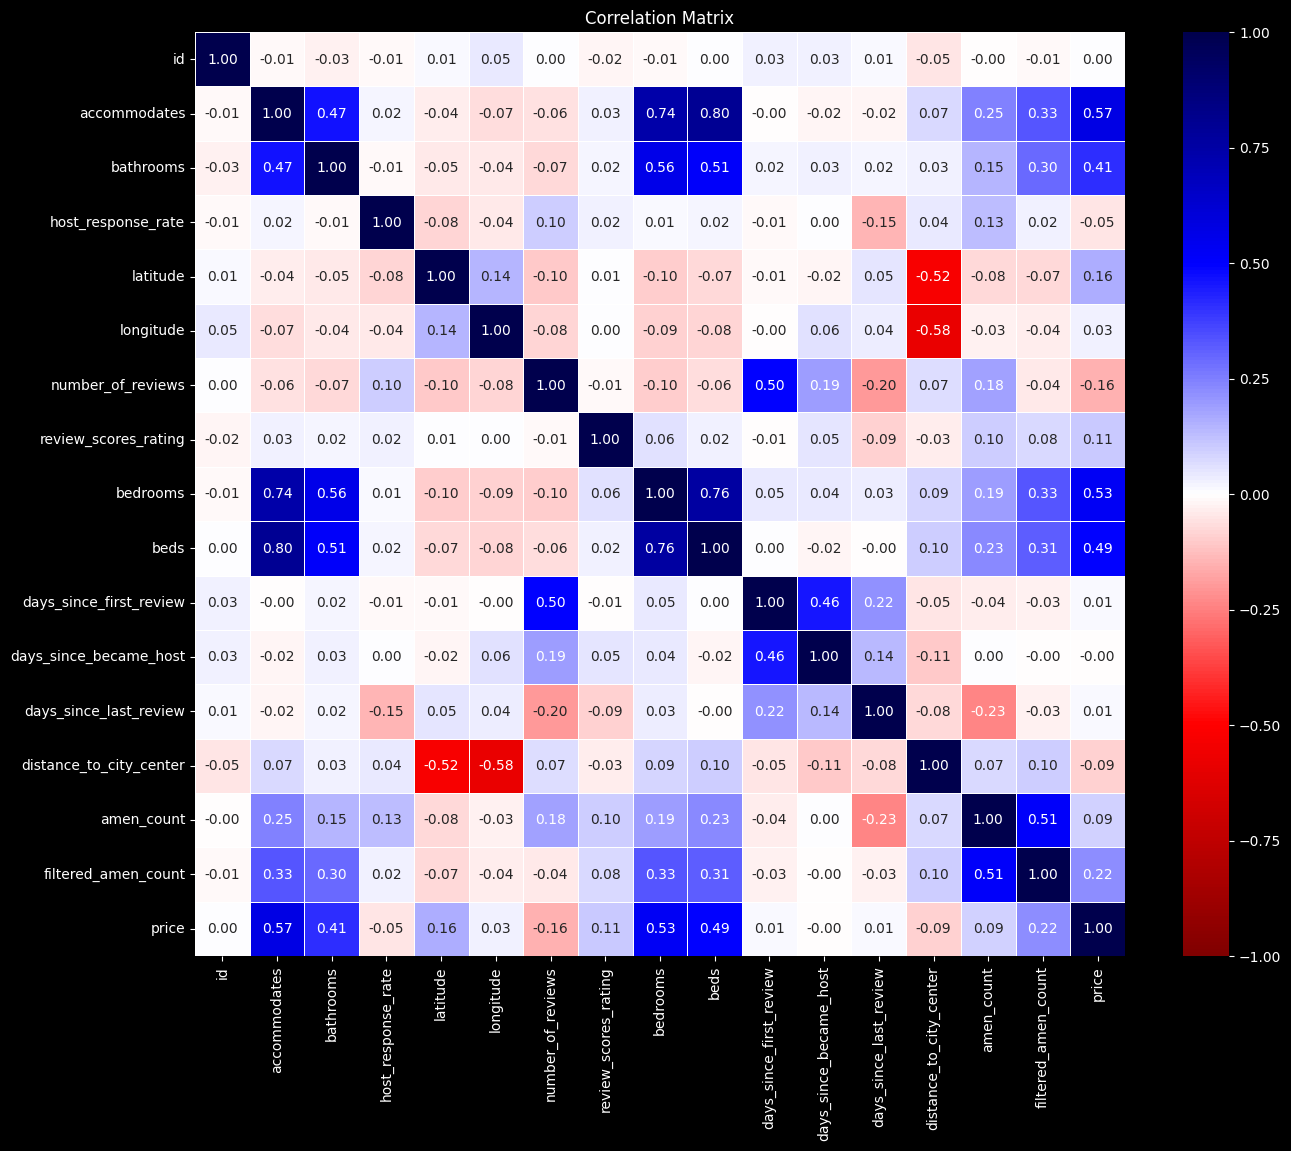

In [ ]:
# menggabungkan prediktor dan target untuk correlation matrix
train = pd.concat([X_train, y_train], axis = 1)

# Menghitung korelasi
numerical_cols = train.select_dtypes('number').columns.to_list()
correlation_matrix = train[numerical_cols].corr()

# Menampilkan korelasi dalam bentuk heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic_r', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# hapus fitur yang valuenya terlalu panjang padahal tidak diperlukan untuk analisis untuk mengurangi beban komputasi
X_train = X_train.drop(['id','name','description','thumbnail_url','amenities'], axis=1)
X_test  =  X_test.drop(['id','name','description','thumbnail_url','amenities'], axis=1)

# hapus fitur host response rate karena missing valuenya >30%, selain itu valuenya hampir semuanya 100
X_train = X_train.drop(['host_response_rate'], axis=1)
X_test  =  X_test.drop(['host_response_rate'], axis=1)

# hapus fitur bertipe datetime karena sudah diwakili oleh kolom days_since
X_train = X_train.drop(['host_since','first_review','last_review'], axis=1)
X_test  =  X_test.drop(['host_since','first_review','last_review'], axis=1)

# hapus sebagian fitur yang saling berkorelasi (threshold= 0.8, sisakan yang korelasinya terhadap harga tertinggi)
X_train = X_train.drop(['beds'], axis=1)
X_test  =  X_test.drop(['beds'], axis=1)

# hapus fitur kategorik yang nilainya didominasi 1 kategori, sedangkan yang lain terlalu jarang
X_train = X_train.drop(['bed_type','host_has_profile_pic'], axis=1)
X_test  =  X_test.drop(['bed_type','host_has_profile_pic'], axis=1)

# hapus fitur zipcode & neighbourhood karena terlalu banyak kategori, sedangkan nilainya bisa diwakili latitude, longitude, & neighbourhood_grouped
X_train = X_train.drop(['zipcode','neighbourhood','zipcode_corrected'], axis=1)
X_test  =  X_test.drop(['zipcode','neighbourhood'], axis=1)

# hapus fitur property_type karena terlalu banyak kategori, dan tidak terlalu berpengaruh pada harga (bahkan cenderung noise setelah saya tes meski sudah digrup)
X_train = X_train.drop(['property_type'], axis=1)
X_test  =  X_test.drop(['property_type'], axis=1)

# hapus fitur fasilitas (karena terlalu banyak tapi tidak terlalu berpengaruh pada harga, bahkan cenderung noise setelah saya tes)
for col in X_train.columns:
  if col.startswith('has_'): # and col not in filtered_amenities:
    X_train = X_train.drop([col], axis=1)

for col in X_test.columns:
  if col.startswith('has_'): # and col not in filtered_amenities:
    X_test = X_test.drop([col], axis=1)

In [ ]:
display(X_train.head())
display(X_test.head())

room_type  accommodates  bathrooms cancellation_policy  \
11184  Entire home/apt             2        1.0            moderate   
9932      Private room             1        1.0            moderate   
68086  Entire home/apt             4        1.0              strict   
23239  Entire home/apt             5        1.0              strict   
68512  Entire home/apt             7        2.0              strict   

       cleaning_fee  host_identity_verified  instant_bookable   latitude  \
11184          True                    True             False  37.763572   
9932           True                    True             False  37.781701   
68086         False                    True             False  37.788711   
23239          True                    True             False  37.746691   
68512          True                    True              True  37.742171   

        longitude  number_of_reviews  review_scores_rating  bedrooms  \
11184 -122.445812                 36                  99.0       1.0   
9932  -122.476470                  1                 100.0       1.0   
68086 -122.410569                 13                  97.0       0.0   
23239 -122.405860                196                  91.0       1.0   
68512 -122.422765                  2                  80.0       3.0   

       days_since_first_review  days_since_became_host  \
11184                   1449.0                  1831.0   
9932                      89.0                   100.0   
68086                    442.0                   553.0   
23239                   1511.0                  2091.0   
68512                    426.0                   924.0   

       days_since_last_review  distance_to_city_center  \
11184                    70.0                 2.644990   
9932                     89.0                 5.084051   
68086                    22.0                 1.719072   
23239                     9.0                 3.350618   
68512                   162.0                 3.644763   

                       neighbourhood_grouped property_type_grouped  \
11184           Historic & Cultural Quarters             apartment   
9932   Suburban & Residential Neighbourhoods             apartment   
68086         Downtown & Central Attractions                others   
23239  Suburban & Residential Neighbourhoods             apartment   
68512  Suburban & Residential Neighbourhoods                 house   

       amen_count  filtered_amen_count  
11184          15                    4  
9932            9                    1  
68086          23                    2  
23239          25                    5  
68512          33                    3

room_type  accommodates  bathrooms cancellation_policy  \
27616     Private room             2        1.0            flexible   
38543     Private room             2        1.0            flexible   
2496   Entire home/apt             2        1.0              strict   
42011  Entire home/apt             2        1.0            moderate   
57617     Private room             2        1.0              strict   

       cleaning_fee  host_identity_verified  instant_bookable   latitude  \
27616          True                    True             False  37.771327   
38543          True                   False              True  37.788934   
2496           True                    True             False  37.716925   
42011         False                    True             False  37.778887   
57617          True                    True             False  37.743179   

        longitude  number_of_reviews  review_scores_rating  bedrooms  \
27616 -122.439489                  2                  80.0       1.0   
38543 -122.405020                 83                  87.0       1.0   
2496  -122.481370                  3                 100.0       1.0   
42011 -122.406381                 32                  95.0       1.0   
57617 -122.498255                 57                  92.0       1.0   

       days_since_first_review  days_since_became_host  \
27616                    756.0                    1353   
38543                    304.0                     391   
2496                     860.0                    1652   
42011                    786.0                    1535   
57617                    506.0                    1080   

       days_since_last_review                  neighbourhood_grouped  \
27616                    68.0           Historic & Cultural Quarters   
38543                     1.0         Downtown & Central Attractions   
2496                    813.0  Suburban & Residential Neighbourhoods   
42011                    14.0         Downtown & Central Attractions   
57617                    19.0  Suburban & Residential Neighbourhoods   

      property_type_grouped  amen_count  filtered_amen_count  \
27616             apartment           6                    3   
38543                others          10                    3   
2496              apartment          10                    3   
42011                others           9                    3   
57617                 house           9                    2   

       distance_to_city_center  
27616                 1.813741  
38543                 2.007708  
2496                  8.440097  
42011                 1.229335  
57617                 7.789711

### Feature Scaling

Saya tidak melakukan scaling, untuk alasan interpretasi & karena model ensemble yang saya pakai tidak memerlukan scaling, meskipun model regresi linear membutuhkan scaling tapi daripada saya membuat 2 macam preprocessing, jadi saya jadikan 1 supaya lebih simpel. lagipula model terbaiknya bukan dari regresi linear.  

In [ ]:
# display(X_train.select_dtypes(include=['number']).columns)
# display(X_test.select_dtypes(include=['number']).columns)

# # scaling dengan standard scaler
# scaler = StandardScaler()
# numeric_columns = X_train.select_dtypes(include=['number']).columns

# X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns]) # fit & transform data train
# X_test[numeric_columns] = scaler.transform(X_test[numeric_columns]) # transform data test

### Categorical Encoding

In [ ]:
# cek fitur kategorik
display(X_train.select_dtypes(include=['category']).columns)
display(X_test.select_dtypes(include=['category']).columns)

Index(['room_type', 'cancellation_policy', 'neighbourhood_grouped',
       'property_type_grouped'],
      dtype='object')

Index(['room_type', 'cancellation_policy', 'neighbourhood_grouped',
       'property_type_grouped'],
      dtype='object')

In [ ]:
# cek nilai uniknya
for col in X_train.select_dtypes(include=['category']).columns:
  print(X_train[col].unique())

['Entire home/apt', 'Private room', 'Shared room']
Categories (3, object): ['Entire home/apt', 'Private room', 'Shared room']
['moderate', 'strict', 'flexible', 'super_strict_30', 'super_strict_60']
Categories (5, object): ['flexible', 'moderate', 'strict', 'super_strict_30', 'super_strict_60']
['Historic & Cultural Quarters', 'Suburban & Residential Neighbourhoods', 'Downtown & Central Attractions', 'Trendy & Mixed-Use Communities', 'Upscale & Scenic Residential']
Categories (5, object): ['Downtown & Central Attractions', 'Historic & Cultural Quarters',
                         'Suburban & Residential Neighbourhoods', 'Trendy & Mixed-Use Communities',
                         'Upscale & Scenic Residential']
['apartment', 'others', 'house', 'condominium']
Categories (4, object): ['apartment', 'condominium', 'house', 'others']


In [ ]:
# cek fitur boolean
display(X_train.select_dtypes(include=['bool']).columns)
display(X_test.select_dtypes(include=['bool']).columns)

Index(['cleaning_fee', 'host_identity_verified', 'instant_bookable'], dtype='object')

Index(['cleaning_fee', 'host_identity_verified', 'instant_bookable'], dtype='object')

In [ ]:
# fitur ordinal
cancellation_policy_order = ['flexible', 'moderate', 'strict', 'super_strict_30', 'super_strict_60']

# inisiasi ordinal encoding
encoder_canc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[cancellation_policy_order])

# fit & transform data train
X_train['cancellation_policy_encoded'] = encoder_canc.fit_transform(X_train[['cancellation_policy']])

# transform data test
X_test['cancellation_policy_encoded'] = encoder_canc.transform(X_test[['cancellation_policy']])

# hapus fitur original
X_train = X_train.drop(columns=['cancellation_policy'])
X_test = X_test.drop(columns=['cancellation_policy'])

bool_cols = X_train.select_dtypes(include=['bool']).columns
cat_cols = X_train.select_dtypes(include=['category']).columns
excluded_feature = 'cancellation_policy'
onehot_cols = list(set(bool_cols) | (set(cat_cols) - {excluded_feature}))

# inisiasi one hot encoder
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' untuk menghindari dummy trap

encoded_train = onehot_encoder.fit_transform(X_train[onehot_cols]) # fit & transform data train
encoded_test = onehot_encoder.transform(X_test[onehot_cols]) # transform data test

# Ubah encoded arrays menjadi DataFrame
encoded_feature_names = onehot_encoder.get_feature_names_out(onehot_cols)
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_feature_names, index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_feature_names, index=X_test.index)

# ganti fitur original dengan fitur hasil encoding
X_train_processed = pd.concat([X_train.drop(columns=onehot_cols), encoded_train_df], axis=1)
X_test_processed = pd.concat([X_test.drop(columns=onehot_cols), encoded_test_df], axis=1)

In [ ]:
# Output hasil
display(X_train_processed.head())
display(X_train_processed.info())
display(X_test_processed.head())
display(X_test_processed.info())

accommodates  bathrooms   latitude   longitude  number_of_reviews  \
11184             2        1.0  37.763572 -122.445812                 36   
9932              1        1.0  37.781701 -122.476470                  1   
68086             4        1.0  37.788711 -122.410569                 13   
23239             5        1.0  37.746691 -122.405860                196   
68512             7        2.0  37.742171 -122.422765                  2   

       review_scores_rating  bedrooms  days_since_first_review  \
11184                  99.0       1.0                   1449.0   
9932                  100.0       1.0                     89.0   
68086                  97.0       0.0                    442.0   
23239                  91.0       1.0                   1511.0   
68512                  80.0       3.0                    426.0   

       days_since_became_host  days_since_last_review  \
11184                  1831.0                    70.0   
9932                    100.0                    89.0   
68086                   553.0                    22.0   
23239                  2091.0                     9.0   
68512                   924.0                   162.0   

       distance_to_city_center  amen_count  filtered_amen_count  \
11184                 2.644990          15                    4   
9932                  5.084051           9                    1   
68086                 1.719072          23                    2   
23239                 3.350618          25                    5   
68512                 3.644763          33                    3   

       cancellation_policy_encoded  room_type_Private room  \
11184                          1.0                     0.0   
9932                           1.0                     1.0   
68086                          2.0                     0.0   
23239                          2.0                     0.0   
68512                          2.0                     0.0   

       room_type_Shared room  \
11184                    0.0   
9932                     0.0   
68086                    0.0   
23239                    0.0   
68512                    0.0   

       neighbourhood_grouped_Historic & Cultural Quarters  \
11184                                                1.0    
9932                                                 0.0    
68086                                                0.0    
23239                                                0.0    
68512                                                0.0    

       neighbourhood_grouped_Suburban & Residential Neighbourhoods  \
11184                                                0.0             
9932                                                 1.0             
68086                                                0.0             
23239                                                1.0             
68512                                                1.0             

       neighbourhood_grouped_Trendy & Mixed-Use Communities  \
11184                                                0.0      
9932                                                 0.0      
68086                                                0.0      
23239                                                0.0      
68512                                                0.0      

       neighbourhood_grouped_Upscale & Scenic Residential  \
11184                                                0.0    
9932                                                 0.0    
68086                                                0.0    
23239                                                0.0    
68512                                                0.0    

       property_type_grouped_condominium  property_type_grouped_house  \
11184                                0.0                          0.0   
9932                                 0.0                          0.0   
68086                                0.0                          0.0   
23239          

<class 'pandas.core.frame.DataFrame'>
Index: 5147 entries, 11184 to 9268
Data columns (total 26 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   accommodates                                                 5147 non-null   int64  
 1   bathrooms                                                    5147 non-null   float64
 2   latitude                                                     5147 non-null   float64
 3   longitude                                                    5147 non-null   float64
 4   number_of_reviews                                            5147 non-null   int64  
 5   review_scores_rating                                         5147 non-null   float64
 6   bedrooms                                                     5147 non-null   float64
 7   days_since_first_review                                      5147 non-null   fl

None

accommodates  bathrooms   latitude   longitude  number_of_reviews  \
27616             2        1.0  37.771327 -122.439489                  2   
38543             2        1.0  37.788934 -122.405020                 83   
2496              2        1.0  37.716925 -122.481370                  3   
42011             2        1.0  37.778887 -122.406381                 32   
57617             2        1.0  37.743179 -122.498255                 57   

       review_scores_rating  bedrooms  days_since_first_review  \
27616                  80.0       1.0                    756.0   
38543                  87.0       1.0                    304.0   
2496                  100.0       1.0                    860.0   
42011                  95.0       1.0                    786.0   
57617                  92.0       1.0                    506.0   

       days_since_became_host  days_since_last_review  amen_count  \
27616                    1353                    68.0           6   
38543                     391                     1.0          10   
2496                     1652                   813.0          10   
42011                    1535                    14.0           9   
57617                    1080                    19.0           9   

       filtered_amen_count  distance_to_city_center  \
27616                    3                 1.813741   
38543                    3                 2.007708   
2496                     3                 8.440097   
42011                    3                 1.229335   
57617                    2                 7.789711   

       cancellation_policy_encoded  room_type_Private room  \
27616                          0.0                     1.0   
38543                          0.0                     1.0   
2496                           2.0                     0.0   
42011                          1.0                     0.0   
57617                          2.0                     1.0   

       room_type_Shared room  \
27616                    0.0   
38543                    0.0   
2496                     0.0   
42011                    0.0   
57617                    0.0   

       neighbourhood_grouped_Historic & Cultural Quarters  \
27616                                                1.0    
38543                                                0.0    
2496                                                 0.0    
42011                                                0.0    
57617                                                0.0    

       neighbourhood_grouped_Suburban & Residential Neighbourhoods  \
27616                                                0.0             
38543                                                0.0             
2496                                                 1.0             
42011                                                0.0             
57617                                                1.0             

       neighbourhood_grouped_Trendy & Mixed-Use Communities  \
27616                                                0.0      
38543                                                0.0      
2496                                                 0.0      
42011                                                0.0      
57617                                                0.0      

       neighbourhood_grouped_Upscale & Scenic Residential  \
27616                                                0.0    
38543                                                0.0    
2496                                                 0.0    
42011                                                0.0    
57617                                                0.0    

       property_type_grouped_condominium  property_type_grouped_house  \
27616                                0.0                          0.0   
38543                                0.0                          0.0   
2496                                 0.0                          0.0   
42011          

<class 'pandas.core.frame.DataFrame'>
Index: 1287 entries, 27616 to 26541
Data columns (total 26 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   accommodates                                                 1287 non-null   int64  
 1   bathrooms                                                    1287 non-null   float64
 2   latitude                                                     1287 non-null   float64
 3   longitude                                                    1287 non-null   float64
 4   number_of_reviews                                            1287 non-null   int64  
 5   review_scores_rating                                         1287 non-null   float64
 6   bedrooms                                                     1287 non-null   float64
 7   days_since_first_review                                      1287 non-null   f

None

# Modeling

In [ ]:
#==== Set Up model ====
lnr = LinearRegression() # base model sebagai pembanding
rlr = Ridge() # regularized base model sebagai pembanding
llr = Lasso() # regularized base model sebagai pembanding
rdf = RandomForestRegressor()
xgb = XGBRegressor()
cat = CatBoostRegressor()
lgb = LGBMRegressor()

ml = [('Linear Regression',lnr),
      ('Ridge Regression',rlr),
      ('Lasso Regression',llr),
      ('Random Forest',rdf),
      ('XGBoost',xgb),
      ("LightGBM",lgb),
      ('Catboost',cat)
      ]

In [ ]:
%%time

r2_train = []
r2_test = []
mae_train = []
mae_test = []
mape_train = []
mape_test = []
rmse_train = []
rmse_test = []
models = []

# tes performa model pada data yang berbeda-beda sekedar untuk mencari model yang pantas di tuning
# seperti metode bootstrap tapi tanpa pengembalian
for model in ml:
  for x in range(0,40):
    X_val_train,X_val_test,y_val_train,y_val_test = train_test_split(X_train_processed,y_train,test_size=0.2) # tidak mensetting random state pada train test split
    model[1].fit(X_val_train,y_val_train)

    predict_train = model[1].predict(X_val_train)
    predict_test = model[1].predict(X_val_test)

    r2_score_train = r2_score(y_val_train,predict_train)
    r2_score_test = r2_score(y_val_test,predict_test)

    mae_score_train = mean_absolute_error(y_val_train,predict_train)
    mae_score_test = mean_absolute_error(y_val_test,predict_test)

    mape_score_train = mean_absolute_percentage_error(y_val_train,predict_train)
    mape_score_test = mean_absolute_percentage_error(y_val_test,predict_test)

    mse_score_train = mean_squared_error(y_val_train,predict_train)
    mse_score_test = mean_squared_error(y_val_test,predict_test)

    rmse_score_train = np.sqrt(mse_score_train)
    rmse_score_test = np.sqrt(mse_score_test)

    r2_train.append(r2_score_train)
    r2_test.append(r2_score_test)
    mae_train.append(mae_score_train)
    mae_test.append(mae_score_test)
    mape_train.append(mape_score_train)
    mape_test.append(mape_score_test)
    rmse_train.append(rmse_score_train)
    rmse_test.append(rmse_score_test)
    models.append(model[0])

df_metrics = pd.DataFrame({'model':models,
                           'r2_score_train':r2_train,
                           'r2_score_test':r2_test,
                           'MAE_train':mae_train,
                           'MAE_test':mae_test,
                           'MAPE_train':mape_train,
                           'MAPE_test':mape_test,
                           'RMSE_train':rmse_train,
                           'RMSE_test':rmse_test})

Streaming output truncated to the last 5000 lines.
6:	learn: 173.3970084	total: 30.5ms	remaining: 4.33s
7:	learn: 170.7053918	total: 34.8ms	remaining: 4.31s
8:	learn: 168.2980530	total: 39.2ms	remaining: 4.31s
9:	learn: 166.0699971	total: 42.6ms	remaining: 4.21s
10:	learn: 164.0153070	total: 45.9ms	remaining: 4.13s
11:	learn: 162.0699949	total: 49.2ms	remaining: 4.05s
12:	learn: 160.3274646	total: 52.6ms	remaining: 3.99s
13:	learn: 158.6505643	total: 55.7ms	remaining: 3.92s
14:	learn: 156.8221878	total: 59.1ms	remaining: 3.88s
15:	learn: 155.1669918	total: 67.9ms	remaining: 4.18s
16:	learn: 153.5620524	total: 73.3ms	remaining: 4.24s
17:	learn: 152.2988348	total: 82ms	remaining: 4.47s
18:	learn: 150.8509508	total: 89.7ms	remaining: 4.63s
19:	learn: 149.6749771	total: 93.6ms	remaining: 4.59s
20:	learn: 148.5104017	total: 96.7ms	remaining: 4.51s
21:	learn: 147.4429375	total: 100ms	remaining: 4.46s
22:	learn: 146.5115439	total: 104ms	remaining: 4.41s
23:	learn: 145.6253929	total: 109ms	rem

In [ ]:
# print performa model
df_metrics

model  r2_score_train  r2_score_test  MAE_train   MAE_test  \
0    Linear Regression        0.454434       0.486417  87.224160  87.995235   
1    Linear Regression        0.461177       0.461659  86.491244  87.783623   
2    Linear Regression        0.456319       0.477978  86.682036  91.578387   
3    Linear Regression        0.454944       0.484714  88.467632  85.653637   
4    Linear Regression        0.473598       0.410482  86.983129  89.589480   
..                 ...             ...            ...        ...        ...   
275           Catboost        0.862663       0.482816  45.783495  85.331537   
276           Catboost        0.864324       0.508366  46.168857  84.810384   
277           Catboost        0.866350       0.461103  46.168334  79.476961   
278           Catboost        0.869712       0.473727  45.329239  84.288903   
279           Catboost        0.864667       0.543422  47.144242  78.963233   

     MAPE_train  MAPE_test  RMSE_train   RMSE_test  
0      0.481024   0.456354  150.274976  152.193991  
1      0.480669   0.437174  149.035886  156.975797  
2      0.479519   0.487293  149.957284  153.450757  
3      0.481540   0.495075  151.320525  148.262891  
4      0.480059   0.456325  148.376147  159.958008  
..          ...        ...         ...         ...  
275    0.258533   0.425521   72.822395  170.227094  
276    0.257604   0.433271   73.992794  155.652332  
277    0.258956   0.359089   74.850283  152.279275  
278    0.255576   0.403002   73.617176  152.676685  
279    0.259001   0.468142   75.516784  138.600464  

[280 rows x 9 columns]

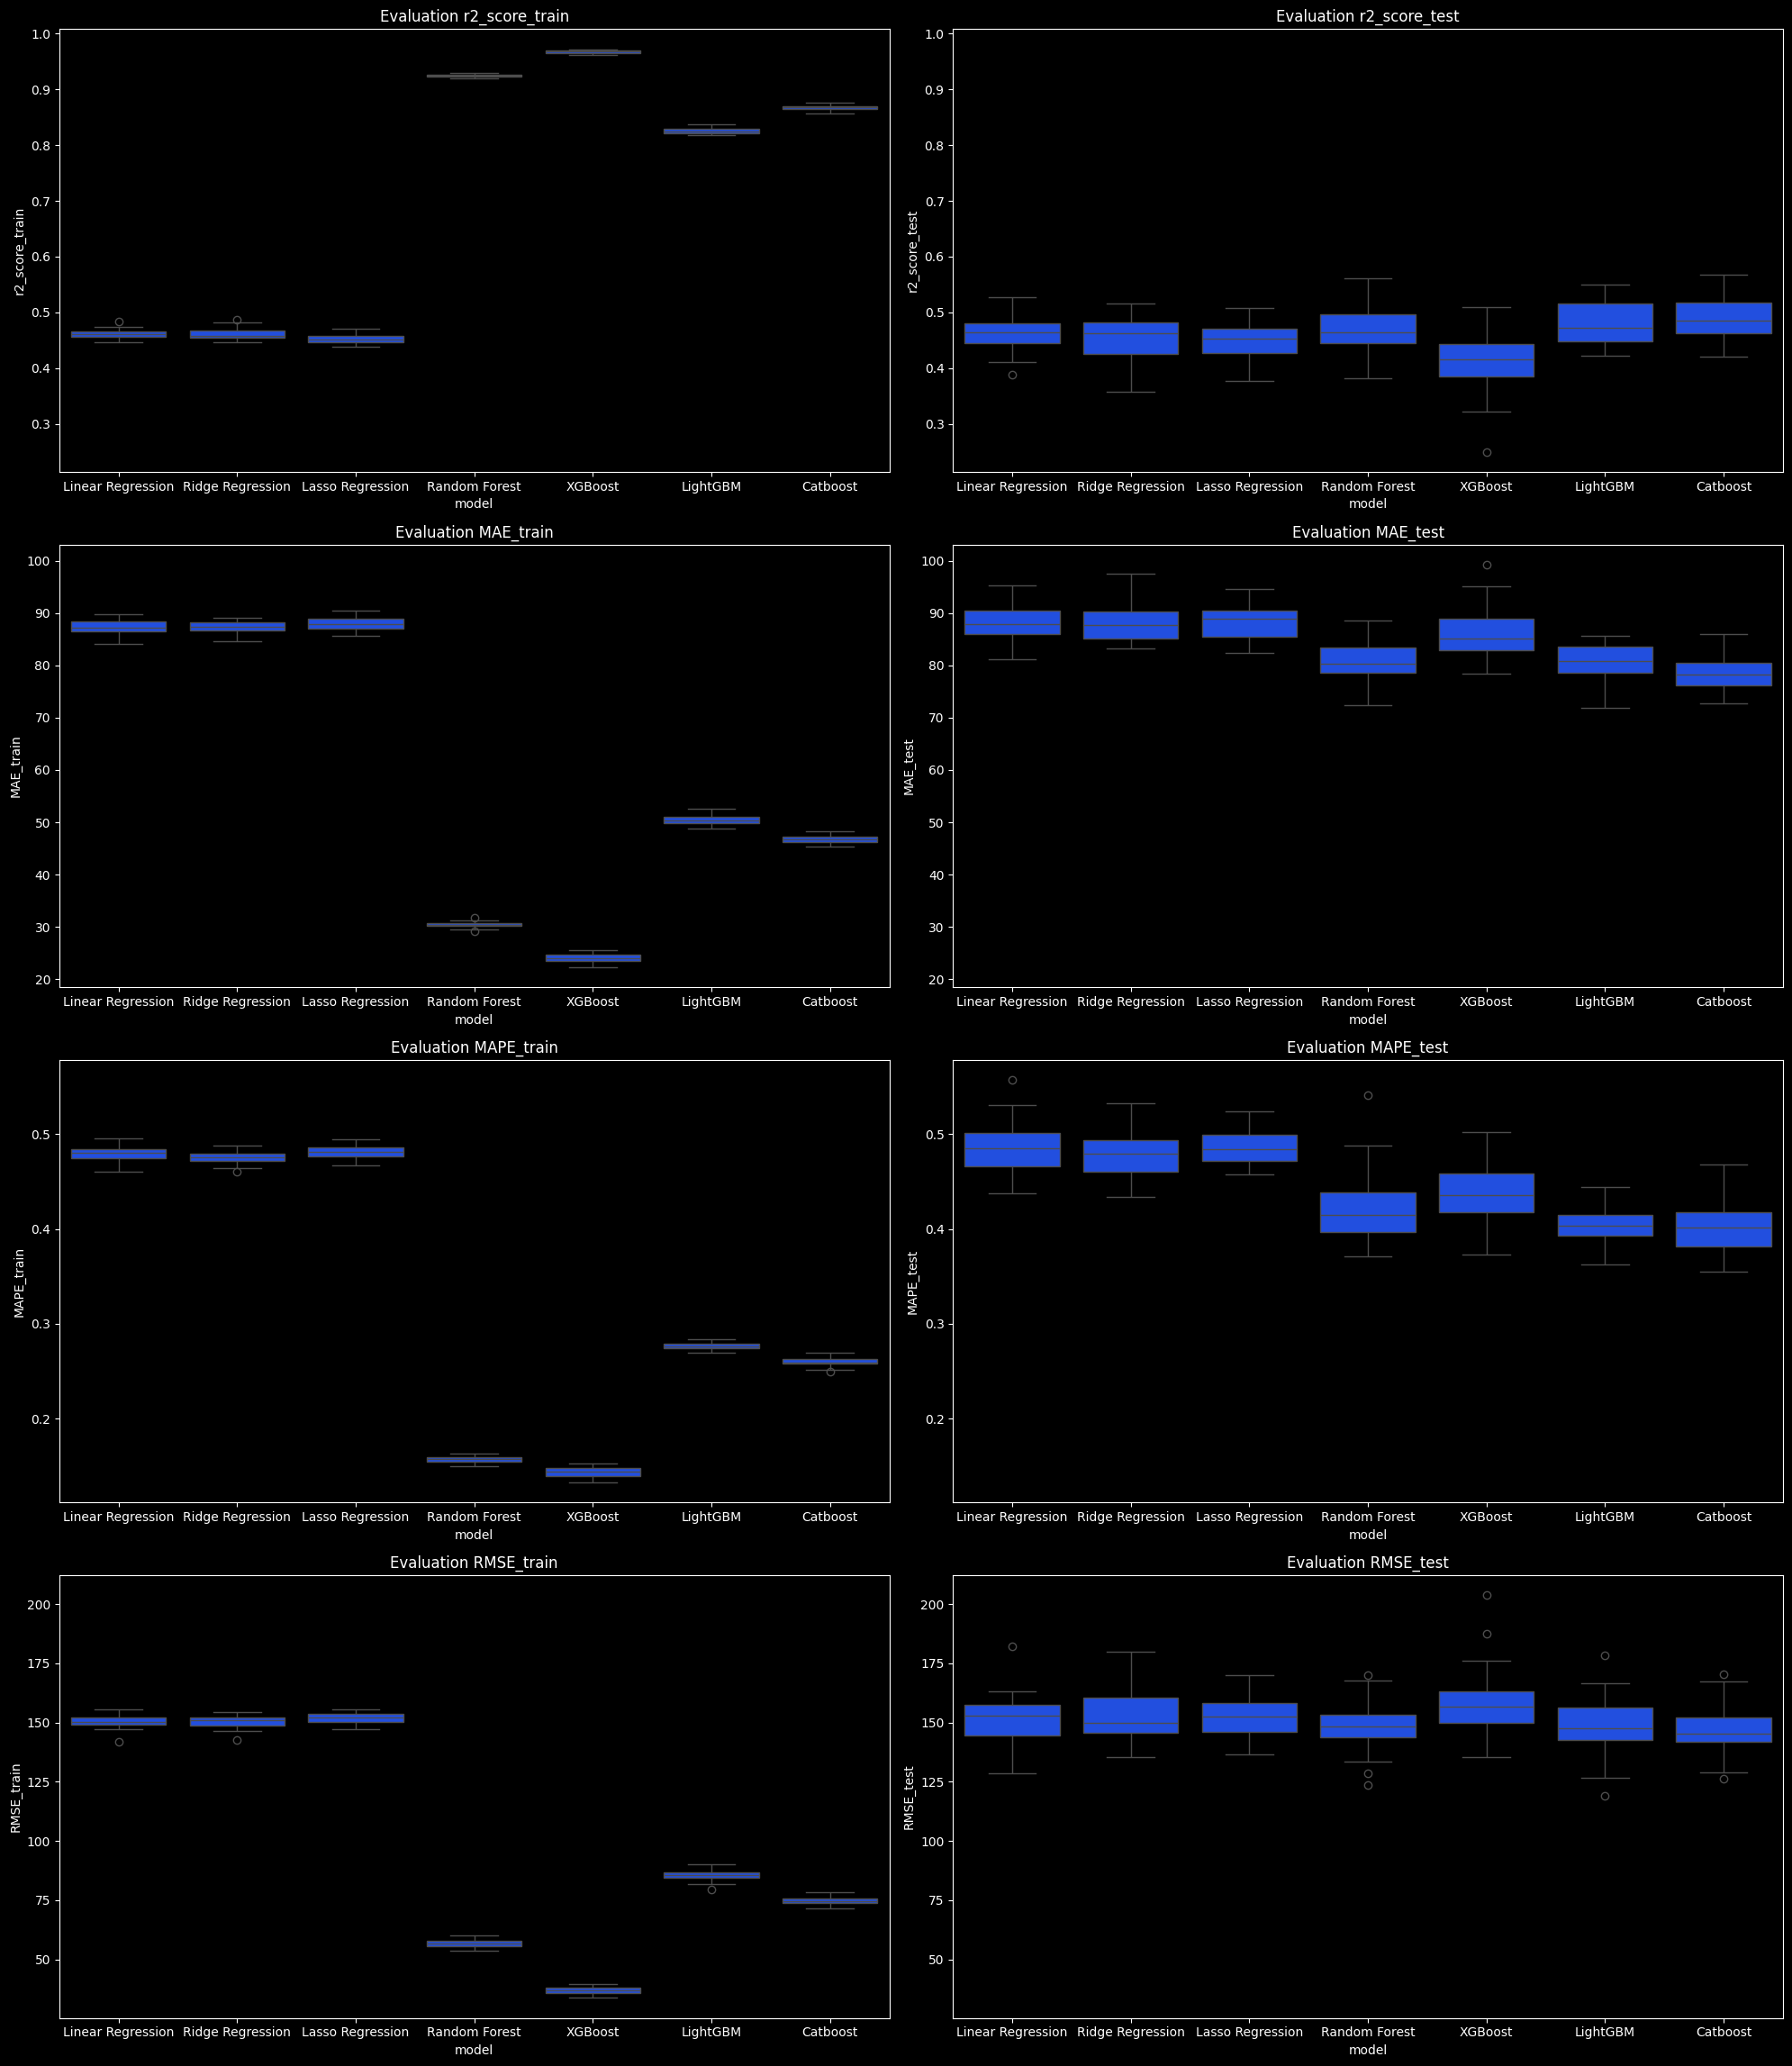

In [ ]:
# Membuat subplot
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

# Flatten axes agar bisa iterasi dengan mudah
axes = axes.flatten()

# Membuat countplot untuk setiap fitur
for i, metric in enumerate(df_metrics.columns[1:]):
  sns.boxplot(data=df_metrics, x='model', y=metric, ax=axes[i])
  axes[i].set_title(f"Evaluation {metric}")

r2_score_max = max(df_metrics['r2_score_train'].max(), df_metrics['r2_score_test'].max())
mae_max = max(df_metrics['MAE_train'].max(), df_metrics['MAE_test'].max())
mape_max = max(df_metrics['MAPE_train'].max(), df_metrics['MAPE_test'].max())
rmse_max = max(df_metrics['RMSE_train'].max(), df_metrics['RMSE_test'].max())
r2_score_min = min(df_metrics['r2_score_train'].min(), df_metrics['r2_score_test'].min())
mae_min = min(df_metrics['MAE_train'].min(), df_metrics['MAE_test'].min())
mape_min = min(df_metrics['MAPE_train'].min(), df_metrics['MAPE_test'].min())
rmse_min = min(df_metrics['RMSE_train'].min(), df_metrics['RMSE_test'].min())
r2_score_range = r2_score_max - r2_score_min
mae_range = mae_max - mae_min
mape_range = mape_max - mape_min
rmse_range = rmse_max - rmse_min

# menyamakan sumbu y pada data train dan test untuk memudahkan perbandingan secara objektif
axes[0].set_ylim(r2_score_min - r2_score_range*0.05, r2_score_max + r2_score_range*0.05)
axes[1].set_ylim(r2_score_min - r2_score_range*0.05, r2_score_max + r2_score_range*0.05)
axes[2].set_ylim(mae_min - mae_range*0.05, mae_max + mae_range*0.05)
axes[3].set_ylim(mae_min - mae_range*0.05, mae_max + mae_range*0.05)
axes[4].set_ylim(mape_min - mape_range*0.05, mape_max + mape_range*0.05)
axes[5].set_ylim(mape_min - mape_range*0.05, mape_max + mape_range*0.05)
axes[6].set_ylim(rmse_min - rmse_range*0.05, rmse_max + rmse_range*0.05)
axes[7].set_ylim(rmse_min - rmse_range*0.05, rmse_max + rmse_range*0.05)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # mengatur layout dan spasi
plt.show()

In [ ]:
df_styled = df_metrics.groupby('model').mean()
df_styled = df_styled.style.highlight_max(color='crimson', axis=0).highlight_min(color='blue', axis=0)
df_styled

In [ ]:
df_styled = df_metrics.groupby('model').std()
df_styled = df_styled.style.highlight_min(color='blue', axis=0)
df_styled

**Kesimpulan**

Model berbasis regresi linear underfitting, sedangkan ensemble model overfitting. performa pada data test tidak jauh berbeda antara keduanya jika dilihat dari mean dan standar deviasinya, namun model ensemble sedikit lebih baik. Disini saya menggunakan MAPE & RMSE sebagai metrik utama.

Saya memilih MAPE karena mengukur error dalam persentase, sehingga error yang selisih harga prediksi dan aktual yang besar pada penginapan yang mahal bobotnya kurang lebih sama dengan selisih harga prediksi dan aktual yang kecil pada penginapan yang murah. Ini sejalan dengan banyaknya penginapan yang relatif murah sehingga cukup penting untuk menentukan harga yang yagn kompetitif, sedangkan penginapan eksklusif cenderung sedikit sehingga bisa lebih leluasa dalam menentukan harga.  

Saya memilih RMSE karena prediksi harga penginapan yang jauh berbeda dari harga ideal akibatnya cukup fatal, jika terlalu mahal, maka penginapan menjadi tidak laku. Jika terlalu murah maka akan mengurangi keuntungan secara drastis. sedangkan harga yang tidak auh berbeda dengan harga asli tidak terlalu bermasalah dalam mempengaruhi performa penginapan.

Saya memilih catboost sebagai model terbaik karena nilai metriknya terbaik, terutama MAPE & RMSE.

Learning rate set to 0.05304
0:	learn: 200.9974284	total: 8.81ms	remaining: 8.8s
1:	learn: 197.0301204	total: 13.5ms	remaining: 6.71s
2:	learn: 193.0518736	total: 17.3ms	remaining: 5.75s
3:	learn: 189.5204986	total: 21.1ms	remaining: 5.25s
4:	learn: 186.4649956	total: 24.8ms	remaining: 4.94s
5:	learn: 183.5937455	total: 28.7ms	remaining: 4.76s
6:	learn: 180.5777995	total: 32.5ms	remaining: 4.61s
7:	learn: 178.0340440	total: 47.8ms	remaining: 5.92s
8:	learn: 175.5253734	total: 51.5ms	remaining: 5.67s
9:	learn: 173.3382445	total: 55.1ms	remaining: 5.46s
10:	learn: 171.0500230	total: 59.2ms	remaining: 5.32s
11:	learn: 168.8072126	total: 62.7ms	remaining: 5.16s
12:	learn: 166.9986623	total: 66.6ms	remaining: 5.06s
13:	learn: 165.1195666	total: 70.4ms	remaining: 4.96s
14:	learn: 163.4995211	total: 78.7ms	remaining: 5.17s
15:	learn: 161.8496245	total: 86.2ms	remaining: 5.3s
16:	learn: 160.2324972	total: 95.1ms	remaining: 5.5s
17:	learn: 158.9059027	total: 107ms	remaining: 5.82s
18:	learn: 15

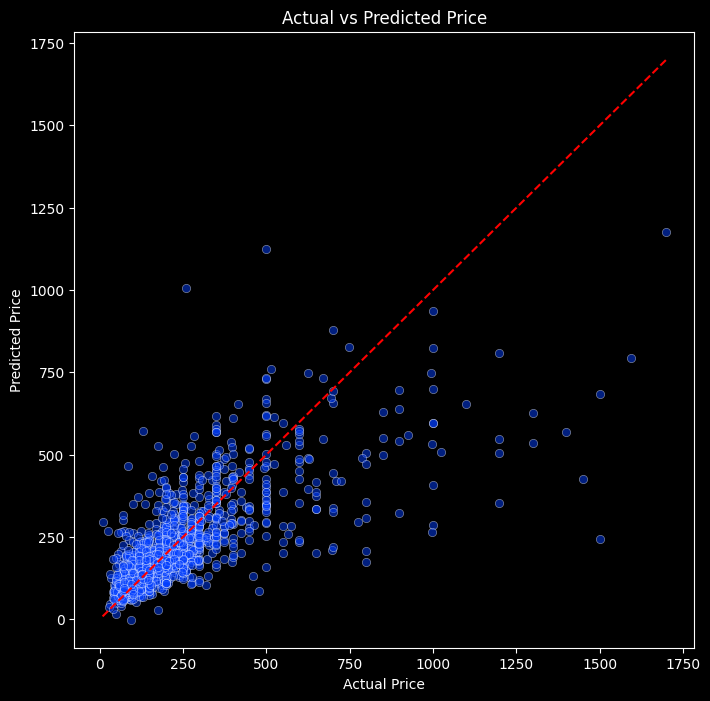

In [ ]:
best_model = CatBoostRegressor()
best_model.fit(X_train_processed, y_train)
y_predicted = best_model.predict(X_test_processed) # Prediksi dari model

# Buat scatter plot
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_predicted, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle="--") # Garis y=x
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [ ]:
# Hitung metrik evaluasi model tanpa tuning
r2   = r2_score(y_test, y_predicted)
mae  = mean_absolute_error(y_test, y_predicted)
mape = mean_absolute_percentage_error(y_test, y_predicted)
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))

# hasil evaluasi pada data test
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.54
MAE: 76.65
MAPE: 38.72%
RMSE: 137.86


## Hyperparameter Tuning

In [ ]:
%%time
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Fungsi untuk optimasi hyperparameter
def objective(trial):
  params = {
    'loss_function': 'MAPE',
    'iterations': trial.suggest_int('iterations', 50, 500),  # Kurangi jumlah pohon agar tidak terlalu lama
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),  # Learning rate kecil untuk belajar perlahan
    'depth': trial.suggest_int('depth', 4, 8),  # Kurangi kedalaman agar tidak terlalu overfit
    'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Sampling lebih sedikit untuk mengurangi overfitting
    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 1.0),  # Sampling fitur lebih terbatas
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),  # Minimum data lebih tinggi agar model lebih stabil
    'verbose': 0
  }

  model = CatBoostRegressor(**params, random_state=42)

  # Evaluasi model dengan cross-validation
  scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring=mape_scorer, n_jobs=-1)
  return -np.mean(scores)

  # scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='neg_root_mean_squared_error')
  # return -scores.mean()  # Karena cross_val_score mengembalikan negatif MAPE

# Jalankan Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=300) # 50 percobaan atau maksimal 5 menit

[I 2025-02-06 14:36:46,464] A new study created in memory with name: no-name-5defa7e0-b260-491e-acf5-fcd9a8dd95f3
[I 2025-02-06 14:36:58,553] Trial 0 finished with value: 0.4412939093209493 and parameters: {'iterations': 80, 'learning_rate': 0.005384054606003335, 'depth': 6, 'subsample': 0.9407073116688955, 'colsample_bylevel': 0.8532137879699115, 'min_data_in_leaf': 32}. Best is trial 0 with value: 0.4412939093209493.
[I 2025-02-06 14:37:07,024] Trial 1 finished with value: 0.3743795926655914 and parameters: {'iterations': 328, 'learning_rate': 0.06245291653765035, 'depth': 4, 'subsample': 0.9007167978207304, 'colsample_bylevel': 0.9610298154178618, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.3743795926655914.
[I 2025-02-06 14:37:48,060] Trial 2 finished with value: 0.34391592968660534 and parameters: {'iterations': 456, 'learning_rate': 0.06596862886243612, 'depth': 8, 'subsample': 0.7993646020123929, 'colsample_bylevel': 0.7683713859504703, 'min_data_in_leaf': 36}. Best i

CPU times: user 4.78 s, sys: 874 ms, total: 5.65 s
Wall time: 5min 5s


In [ ]:
# Hasil terbaik
print("Best parameters:", study.best_params)
print("Best MAPE in cross validation:", study.best_value)

Best parameters: {'iterations': 456, 'learning_rate': 0.06596862886243612, 'depth': 8, 'subsample': 0.7993646020123929, 'colsample_bylevel': 0.7683713859504703, 'min_data_in_leaf': 36}
Best MAPE in cross validation: 0.34391592968660534


0:	learn: 200.1422739	total: 45.3ms	remaining: 20.6s
1:	learn: 195.0872824	total: 76.8ms	remaining: 17.4s
2:	learn: 190.3684751	total: 107ms	remaining: 16.1s
3:	learn: 186.3133901	total: 131ms	remaining: 14.8s
4:	learn: 182.3493892	total: 159ms	remaining: 14.3s
5:	learn: 178.4201611	total: 186ms	remaining: 14s
6:	learn: 175.2007756	total: 215ms	remaining: 13.8s
7:	learn: 172.2809320	total: 239ms	remaining: 13.4s
8:	learn: 169.4814095	total: 266ms	remaining: 13.2s
9:	learn: 166.7107693	total: 290ms	remaining: 13s
10:	learn: 164.2443757	total: 310ms	remaining: 12.6s
11:	learn: 161.9006483	total: 341ms	remaining: 12.6s
12:	learn: 159.8064786	total: 362ms	remaining: 12.3s
13:	learn: 157.8486661	total: 386ms	remaining: 12.2s
14:	learn: 156.0085620	total: 401ms	remaining: 11.8s
15:	learn: 154.4579336	total: 428ms	remaining: 11.8s
16:	learn: 152.8847309	total: 448ms	remaining: 11.6s
17:	learn: 151.3408246	total: 466ms	remaining: 11.3s
18:	learn: 149.9879632	total: 494ms	remaining: 11.4s
19:	l

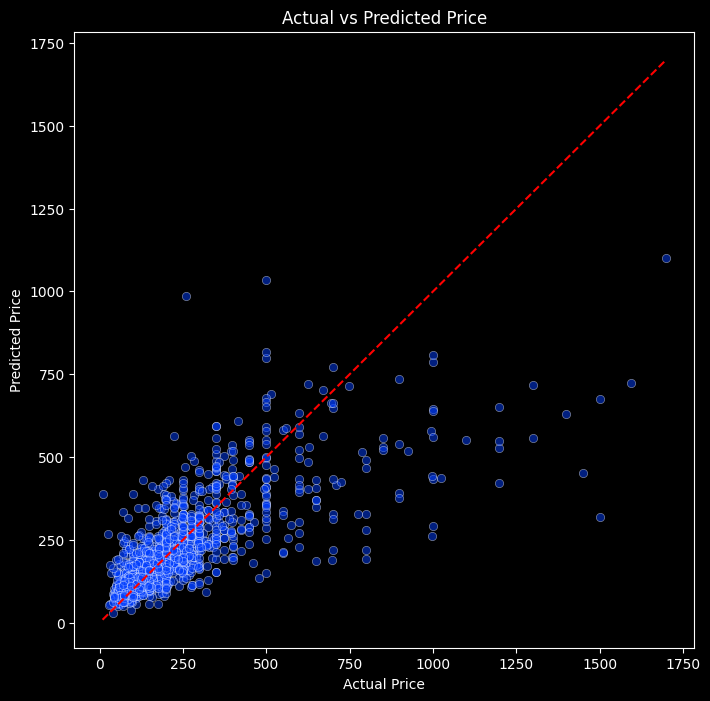

In [ ]:
# scatterplot untuk membandingkan harga asli dengan prediksi
best_params = study.best_params  # Ambil hyperparameter terbaik
tuned_model = CatBoostRegressor(**best_params, random_state=42)
tuned_model.fit(X_train_processed, y_train)
y_predicted = tuned_model.predict(X_test_processed) # Prediksi dari model

# Buat scatter plot
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_predicted, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle="--") # Garis y=x
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [ ]:
# Hitung metrik evaluasi model hasil tuning
r2   = r2_score(y_test, y_predicted)
mae  = mean_absolute_error(y_test, y_predicted)
mape = mean_absolute_percentage_error(y_test, y_predicted)
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))

# hasil evaluasi pada data test
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.54
MAE: 76.58
MAPE: 39.12%
RMSE: 137.04


# Interpretasi Model Terbaik
Performa model catboost relatif sama setelah hyperparameter tuning berkali-kali. tapi saya putuskan untuk pakai model hasil tuning karena setidaknya skor lebih bagus untuk 2 metrik.

## Permutation Feature Importance

In [ ]:
best_model_exp = dx.Explainer(best_model, X_train_processed, y_train, label = "Best Model's Feature Importance", verbose=False)
best_model_exp.model_parts(B=100).plot(max_vars=len(X_train_processed.columns))

Insight:  
accommodates & bedrooms memiliki importance terbesar dalam mempengaruhi performa model. Namun, keduanya lumayan berkorelasi (0.74), sehingga nilai importance yang sebenarnya mungkin lebih tinggi.  
Ternyata jumlah review jauh lebih berkorelasi dengan harga ketimbang rating penginapan.  
Faktor lokasi cukup berkorelasi dalam penentuan harga penginapan di san francisco, dengan faktor terkuatnya yaitu latitude, longitude, & distance to city center.  
Seperti pada hasil EDA, tipe kamar memiliki korelasi yang kuat terhadap harga, sedangkan tipe properti, dan neighbourhood tidak.  
Pengalaman host yang diestimasi oleh days_since_became_host cukup berkorelasi terhadap harga.  

## Partial Dependence Plot

In [ ]:
best_model_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 26/26 [00:02<00:00,  9.20it/s]


Insight:
Harga penginapan meningkat seiring dengan bertambahnya jumlah tamu yang dapat ditampung. Harga penginapan juga meningkat seiring bertambahnya kamar mandi dan kamar tidur, namun harga cenderung stagnan jika jumlah kamar mandi dan kamar tidur >=5.  
Harga penginapan di sebelah utara/barat San Francisco cenderung lebih mahal.  
Ternyata penginapan yang punya sedikit review harganya cenderung lebih mahal.  
Harga penginapan cenderung naik jika rating >89, kurang dari itu stagnan.  
Ternyata harga penginapan yang punya banyak fasilitas cenderung murah tidak peduli apakah fasilitasnya berkorelasi terhadap harga atau tidak.  
Harga cenderung mahal ketika tipe kamar bukan private room/ shared room. Ini berarti harga penginapan bertipe kamar entire house/apartment lebih mahal.